In [1]:
import findspark
findspark.init()
import pyspark
from random import random
from pyspark import SparkContext

from pyspark.ml.clustering import KMeans
from pyspark.mllib.clustering import KMeans

In [2]:
import os
port = 4040 + hash(os.getcwd().split("/")[2])%200
config = pyspark.SparkConf().set('spark.executor.memory', '512M')\
         .set('spark.cores.max', '12')\
         .set('spark.port.maxRetries','200')\
         .set('spark.ui.port', port)    
print port,     os.getcwd().split("/")[2]


4115 srs418


In [3]:
ss = pyspark.sql.SparkSession.builder.config(conf = config).getOrCreate()
sc = ss.sparkContext

In [4]:
!ls /scratch/ISE495/2019_project_data/group-7

lyrics.csv  songdata.csv


In [ ]:
songsd = sc.textFile('/scratch/ISE495/2019_project_data/group-7/songdata.csv')
songsd.take(2)

In [4]:
song = sc.textFile('/scratch/ISE495/2019_project_data/group-7/lyrics.csv')
song.take(2)

[u'index,song,year,artist,genre,lyrics',
 u'0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?']

In [1]:
import pandas as pd

df = pd.read_csv('lyrics.csv')
print(df.head)       

<bound method NDFrame.head of          index                                               song  year  \
0            0                                          ego-remix  2009   
1            1                                       then-tell-me  2009   
2            2                                            honesty  2009   
3            3                                    you-are-my-rock  2009   
4            4                                      black-culture  2009   
5            5                             all-i-could-do-was-cry  2009   
6            6                                 once-in-a-lifetime  2009   
7            7                                            waiting  2009   
8            8                                          slow-love  2009   
9            9                              why-don-t-you-love-me  2009   
10          10                                      save-the-hero  2009   
11          11                                          telephone  200

In [2]:
df['lyrics'] = df['lyrics'].str.replace('\n',' ')

print(df.head)

<bound method NDFrame.head of          index                                               song  year  \
0            0                                          ego-remix  2009   
1            1                                       then-tell-me  2009   
2            2                                            honesty  2009   
3            3                                    you-are-my-rock  2009   
4            4                                      black-culture  2009   
5            5                             all-i-could-do-was-cry  2009   
6            6                                 once-in-a-lifetime  2009   
7            7                                            waiting  2009   
8            8                                          slow-love  2009   
9            9                              why-don-t-you-love-me  2009   
10          10                                      save-the-hero  2009   
11          11                                          telephone  200

In [7]:
#df__ = ss.read.csv('new_song_file', header = True, inferSchema = True)

In [8]:
#df__.show(10)

In [3]:
df['word_count'] = df['lyrics'].str.split().str.len()
print(df.head)

<bound method NDFrame.head of          index                                               song  year  \
0            0                                          ego-remix  2009   
1            1                                       then-tell-me  2009   
2            2                                            honesty  2009   
3            3                                    you-are-my-rock  2009   
4            4                                      black-culture  2009   
5            5                             all-i-could-do-was-cry  2009   
6            6                                 once-in-a-lifetime  2009   
7            7                                            waiting  2009   
8            8                                          slow-love  2009   
9            9                              why-don-t-you-love-me  2009   
10          10                                      save-the-hero  2009   
11          11                                          telephone  200

In [4]:
df = df.dropna()

In [9]:
song_df = ss.createDataFrame(df)

In [10]:
song_df.show(2)

+-----+------------+----+---------------+-----+--------------------+----------+
|index|        song|year|         artist|genre|              lyrics|word_count|
+-----+------------+----+---------------+-----+--------------------+----------+
|    0|   ego-remix|2009|beyonce-knowles|  Pop|Oh baby, how you ...|     433.0|
|    1|then-tell-me|2009|beyonce-knowles|  Pop|playin' everythin...|     258.0|
+-----+------------+----+---------------+-----+--------------------+----------+
only showing top 2 rows



In [14]:
song_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)



### looking for missing values

In [66]:
from pyspark.sql.functions import lit, col, sum

print("Checking for missing values")
rows = song_df.count()
summary = song_df.describe().filter(col("summary") == "count")
summary.select(*((lit(rows)-col(c)).alias(c) for c in song_df.columns)).show()

Checking for missing values
+-----+----+----+------+-----+------+----------+
|index|song|year|artist|genre|lyrics|word_count|
+-----+----+----+------+-----+------+----------+
|  0.0| 0.0| 0.0|   0.0|  0.0|   0.0|       0.0|
+-----+----+----+------+-----+------+----------+



In [173]:
print((song_df.count(), len(song_df.columns)))

(266556, 7)


## Dimensions of dataframe - 266556 rows x 7 columns

### basic operations
### let us find the following: number of artists, most songs by an artist, etc

In [70]:
## no of artists
from pyspark.sql.functions import desc

artists = song_df.select('artist').distinct().rdd.map(lambda r: r[0]).count()
song_df.select('artist').distinct().sort('artist', ascending = True).show(10)         #rdd.map(lambda r: r[0]).collect()

print("we have {} unique artists, 10 are shown above in ascending order" .format(artists))

+----------------+
|          artist|
+----------------+
|009-sound-system|
|             047|
|            0510|
|        0510-ent|
|    1-800-zombie|
|   1-girl-nation|
|      1-hundredd|
|           10-cc|
|        10-years|
|      100-demons|
+----------------+
only showing top 10 rows

we have 14543 unique artists, 10 are shown above in ascending order


In [71]:
## artists with max songs , min songs 

import pyspark.sql.functions as f

songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = False).show()
print("the above are artists with most number of songs")

+-----------------+---------------+
|           artist|number of songs|
+-----------------+---------------+
|     dolly-parton|            744|
|       elton-john|            676|
|      chris-brown|            628|
| barbra-streisand|            607|
|        bob-dylan|            596|
|         bee-gees|            591|
|      eddy-arnold|            591|
|           eminem|            578|
|  ella-fitzgerald|            571|
|      david-bowie|            570|
|    american-idol|            568|
|      dean-martin|            560|
|         b-b-king|            543|
|      celine-dion|            540|
|   elvis-costello|            522|
|bruce-springsteen|            509|
|       beach-boys|            495|
|    bill-anderson|            466|
|     eric-clapton|            461|
|      frank-zappa|            457|
+-----------------+---------------+
only showing top 20 rows

the above are artists with most number of songs


### looking at stats before filtering

In [49]:
##by genre

df['word_count'].groupby(df['genre']).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,14387.0,162.334469,72.804954,1.0,113.0,149.0,200.0,1205.0
Electronic,7966.0,161.950038,120.069728,1.0,81.0,141.0,217.0,1667.0
Folk,2243.0,153.589835,106.600718,1.0,91.0,141.0,202.0,2162.0
Hip-Hop,24850.0,426.905634,212.013848,1.0,292.0,421.0,549.0,7106.0
Indie,3149.0,167.481423,94.756959,1.0,105.0,153.0,212.0,1099.0
Jazz,7971.0,146.013298,83.651256,1.0,91.0,128.0,182.5,821.0
Metal,23759.0,142.137001,97.676448,1.0,82.0,127.0,183.0,2104.0
Not Available,23941.0,177.247191,116.720152,1.0,104.0,158.0,228.0,2319.0
Other,5189.0,188.989401,121.341803,1.0,106.0,161.0,240.0,1412.0


looking at some artists in sorted order:


,index,song,year,artist,genre,lyrics,word_count
7294,7294,bill-bailey-wonu2019t-you-please-come-home,2014,bobby-darin,Jazz,"Hey, Bill Bailey, don't look now but somebody'...",243.0
276467,276467,the-jeffrey,2006,brave-combo,Rock,I am the master of my own universe And I dance...,129.0
284501,284501,back-in-your-own-backyard,2007,brenda-lee,Rock,"We leave home expecting to find a blue bird, H...",131.0
283067,283067,part-of-your-world,2013,carly-rae-jepsen,Pop,Look at this stuff Isn't it neat? Wouldn't you...,316.0
212297,212297,frosty-the-snowman,2015,christmas-songs,Other,[Verse 1] Frosty the snowman was a jolly happy...,241.0
105610,105610,my-kind-of-girl-my-kinda-girl,2008,collin-raye,Country,When I saw you buyin' Cosmo and a Hot Rod maga...,226.0
318570,318570,tie-a-yellow-ribbon-round-the-oild-oak-tree,2007,connie-smith,Country,TIE A YELLOW RIBBON 'ROUND THE OLD OAK TREE Wr...,242.0
339343,339343,du-trefonds-des-tenebres,2006,elend,Not Available,"Horror, Lucifer solutus, Anguis a catenis suis...",302.0
173106,173106,ameno,2002,eric-lasvi,Other,Dori me interimo Adapare Dori me Ameno Ameno L...,145.0
216666,216666,take-me-to-church,2015,glee-cast,Not Available,Roderick: My lover's got humour She's the gigg...,524.0


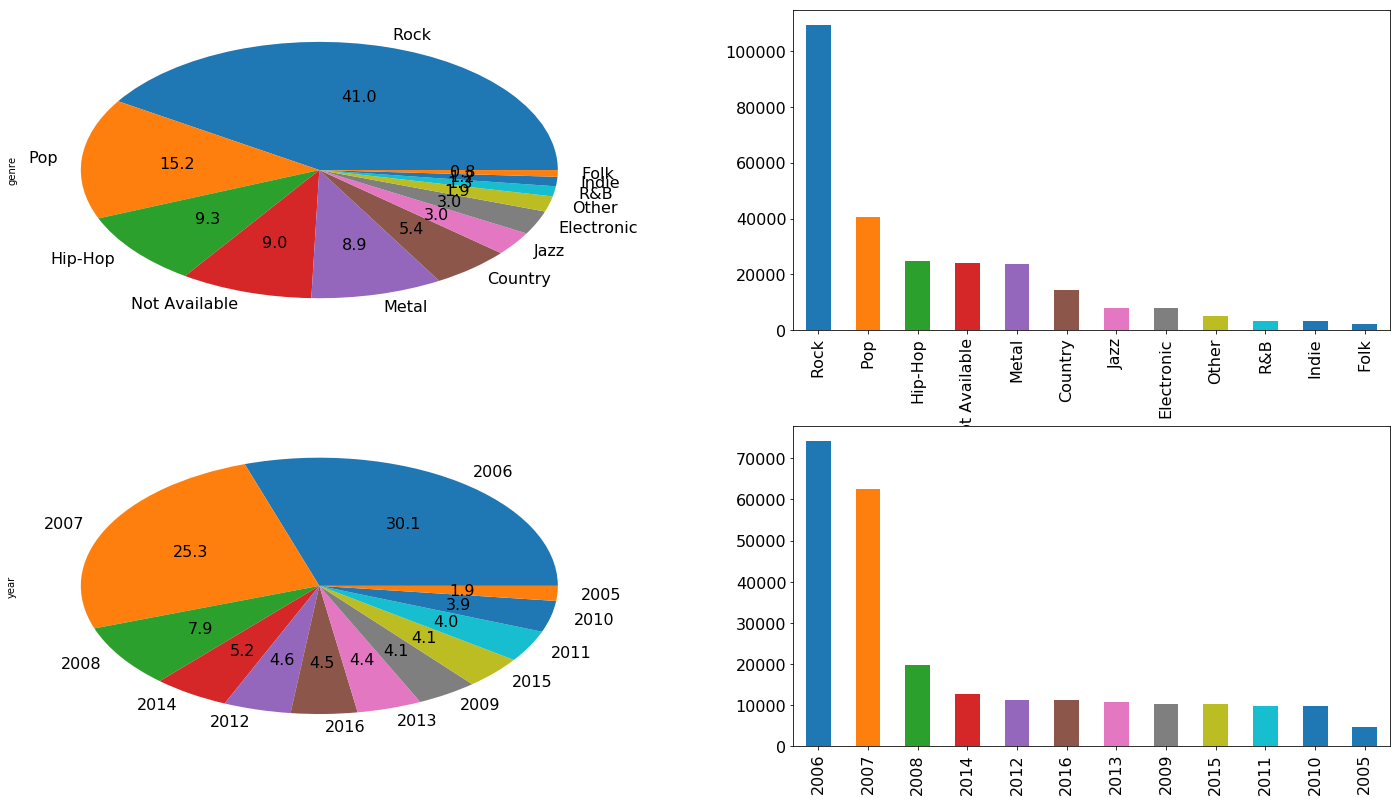

In [25]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

genreCount = df['genre'].value_counts()
yearCount  = df['year'].value_counts().head( 12 )
wordCount = df['word_count'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )

yearCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
yearCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )

#wordCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
#wordCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )


print("looking at some artists in sorted order:")
df.sample(n=10).sort_values('artist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faa58d73a90>]],
      dtype=object)

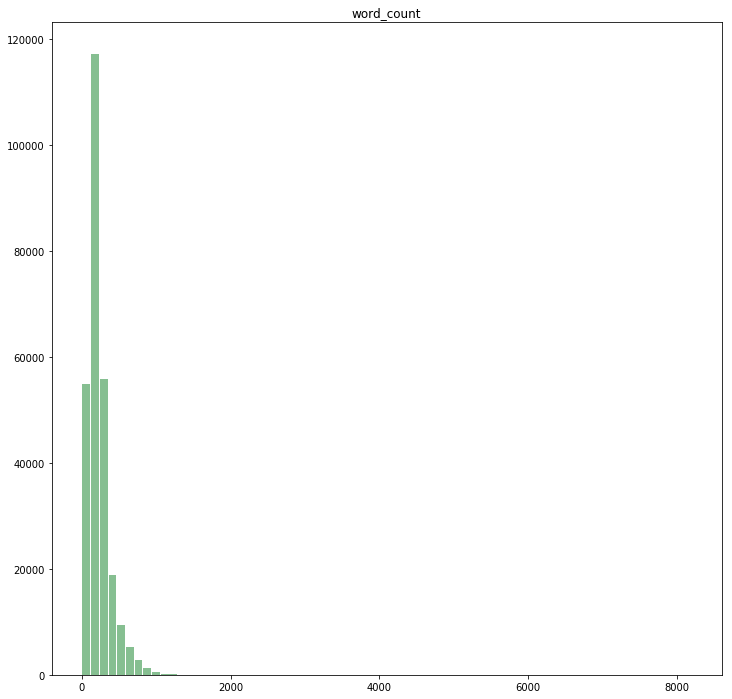

In [49]:
df.hist(column='word_count',bins=70, grid=False, figsize=(12,12), color='#86bf91', zorder=2, rwidth=0.9)

### filter from here

In [10]:
## there are songs with 1 word in lyrics.. lets take threshold = 100 words
## there are also songs with count = 1, lets filter those
song_df = song_df.filter(song_df.word_count >= 100)
song_df = song_df.filter(song_df.word_count <= 1500)
song_df.show(10)

+-----+--------------------+----+---------------+-----+--------------------+----------+
|index|                song|year|         artist|genre|              lyrics|word_count|
+-----+--------------------+----+---------------+-----+--------------------+----------+
|    0|           ego-remix|2009|beyonce-knowles|  Pop|Oh baby, how you ...|     433.0|
|    1|        then-tell-me|2009|beyonce-knowles|  Pop|playin' everythin...|     258.0|
|    2|             honesty|2009|beyonce-knowles|  Pop|If you search For...|     170.0|
|    3|     you-are-my-rock|2009|beyonce-knowles|  Pop|Oh oh oh I, oh oh...|     522.0|
|    4|       black-culture|2009|beyonce-knowles|  Pop|Party the people,...|     312.0|
|    5|all-i-could-do-wa...|2009|beyonce-knowles|  Pop|I heard Church be...|     144.0|
|    6|  once-in-a-lifetime|2009|beyonce-knowles|  Pop|This is just anot...|     295.0|
|    7|             waiting|2009|beyonce-knowles|  Pop|Waiting, waiting,...|     386.0|
|    8|           slow-love|2009

In [15]:
print((song_df.count(), len(song_df.columns)))

(229220, 7)


In [11]:
from pyspark.sql import Window
import pyspark.sql.functions as f

w = Window.partitionBy('artist')
song_df = song_df.withColumn('number_of_songs', f.count('artist').over(w)).sort('artist', 'song')
song_df.show(10)

+------+-------------------+----+----------------+-------------+--------------------+----------+---------------+
| index|               song|year|          artist|        genre|              lyrics|word_count|number_of_songs|
+------+-------------------+----+----------------+-------------+--------------------+----------+---------------+
|331868|  born-to-be-wasted|2011|009-sound-system|          Pop|Oh the beat's gon...|     119.0|              3|
|331869|    speak-to-angels|2015|009-sound-system|          Pop|I was there when ...|     161.0|              3|
|331871|      with-a-spirit|2014|009-sound-system|          Pop|You can be Whatev...|     154.0|              3|
|271937|keep-it-to-yourself|2014|             047|          Pop|Aaah, ah-aaah Is ...|     198.0|              1|
|155200|           monsters|2013|            0510|Not Available|Bradley Too much ...|     575.0|              1|
|210418|           monsters|2013|        0510-ent|Not Available|Bradley Too much ...|     575.0|

In [12]:
song_df = song_df.filter(song_df.number_of_songs >= 15)
song_df.show(10)

+------+--------------------+----+------+-----+--------------------+----------+---------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|
+------+--------------------+----+------+-----+--------------------+----------+---------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|
|238176|      age-of-consent|1995| 10-cc| Rock|I want to meet yo...|     263.0|            142|
|238127|   american-panorama|2006| 10-cc| Rock|Martin Luther B.B...|     210.0|            142|
|238132|  americana-panorama|2006| 10-cc| Rock|Martin Luther B.B...|     210.0|            142|
|238204|  art-for-art-s-sake|2008| 10-cc| Rock|Gimme your body G...|     220.0|            142|
|238073|   art-for-arts-sake|2009| 10-cc| Rock|Gimme your body G...|     220.0|            142|
|238162|        baron-samedi|2006| 10-cc

In [18]:
print((song_df.count(), len(song_df.columns)))

(204321, 8)


### looking at stats after filtering

In [17]:
## no of artists
from pyspark.sql.functions import desc

artists = song_df.select('artist').distinct().rdd.map(lambda r: r[0]).count()
song_df.select('artist').distinct().sort('artist', ascending = True).show(10)         #rdd.map(lambda r: r[0]).collect()

print("we have {} unique artists after filtering, 10 are shown above in ascending order" .format(artists))

+-------------+
|       artist|
+-------------+
|1-girl-nation|
|        10-cc|
|     10-years|
|  100-monkeys|
|10000-maniacs|
|          112|
|    12-stones|
|   13-engines|
|       14-bis|
|16-horsepower|
+-------------+
only showing top 10 rows

we have 4870 unique artists after filtering, 10 are shown above in ascending order


In [153]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with most number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = False).show()


the following are artists with most number of songs, after filtering
+-----------------+---------------+
|           artist|number of songs|
+-----------------+---------------+
|     dolly-parton|            707|
|      chris-brown|            610|
|       elton-john|            607|
|        bob-dylan|            561|
|         bee-gees|            546|
|           eminem|            546|
|    american-idol|            533|
|      celine-dion|            530|
|   elvis-costello|            503|
|      david-bowie|            503|
| barbra-streisand|            502|
|bruce-springsteen|            497|
|         b-b-king|            487|
|      dean-martin|            445|
|  ella-fitzgerald|            444|
|    bill-anderson|            430|
|      eddy-arnold|            426|
|       beach-boys|            410|
|   britney-spears|            393|
|   chamillionaire|            388|
+-----------------+---------------+
only showing top 20 rows



In [155]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with least number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = True).show()


the following are artists with least number of songs, after filtering
+--------------------+---------------+
|              artist|number of songs|
+--------------------+---------------+
|         avi-buffalo|             10|
|        alex-winston|             10|
|   caught-in-the-act|             10|
| artificial-joy-club|             10|
|     fred-eaglesmith|             10|
|              drapht|             10|
|               crest|             10|
|           a-m-drive|             10|
|carrie-hope-fletcher|             10|
|erik-goes-to-germany|             10|
|       38th-parallel|             10|
|      calvert-robert|             10|
|andrew-jackson-jihad|             10|
|     buffalocomotive|             10|
|      the-blaqk-year|             10|
|      donnie-trumpet|             10|
|          bang-tango|             10|
|       above-the-law|             10|
|        ashes-divide|             10|
|       george-nozuka|             10|
+--------------------+-----------

looking at some artists in sorted order:


,index,song,year,artist,genre,lyrics,word_count,number_of_songs
51901,19039,memorie-di-giulia,2006,battiato-franco,Rock,Quel letto d'ottone in cui mi accoglievi giovi...,178.0,139
78884,33931,look-into-my-eyez-atlantis-remix,2006,bone-thugs-n-harmony,Hip-Hop,"We thuggish ruggish niggas always, always And ...",971.0,267
97794,214140,heaven,2007,canaan,Rock,Ascolta il riverbero del silenzio sul fondo de...,18.0,33
102852,39531,get-off-it,2006,casual,Hip-Hop,"Intro: Hah, ay youknowhatI'msayin Hieroglyphic...",431.0,20
117852,108507,hey-you-outside-now,2006,chumbawamba,Rock,One year later This queue never moved I've got...,217.0,423
146604,124574,biggest-fan,2010,dawn-richard,Pop,Tell the truth boy you want me to work you I c...,647.0,94
157501,186598,i-saw-linda-yesterday,2008,dickey-lee,Rock,I Saw Linda Yesterday Dickey Lee Written by Di...,209.0,62
182412,76943,forgiveness,2012,elisa,Rock,I'm lost and scared to live this life I though...,169.0,92
211707,282791,songs-for-women,2011,frank-ocean,Pop,When I was younger I used to wonder like If I ...,297.0,129
235147,86179,independence-day,2007,the-bruisers,Rock,I stood in the middle Watching the scene all a...,132.0,45


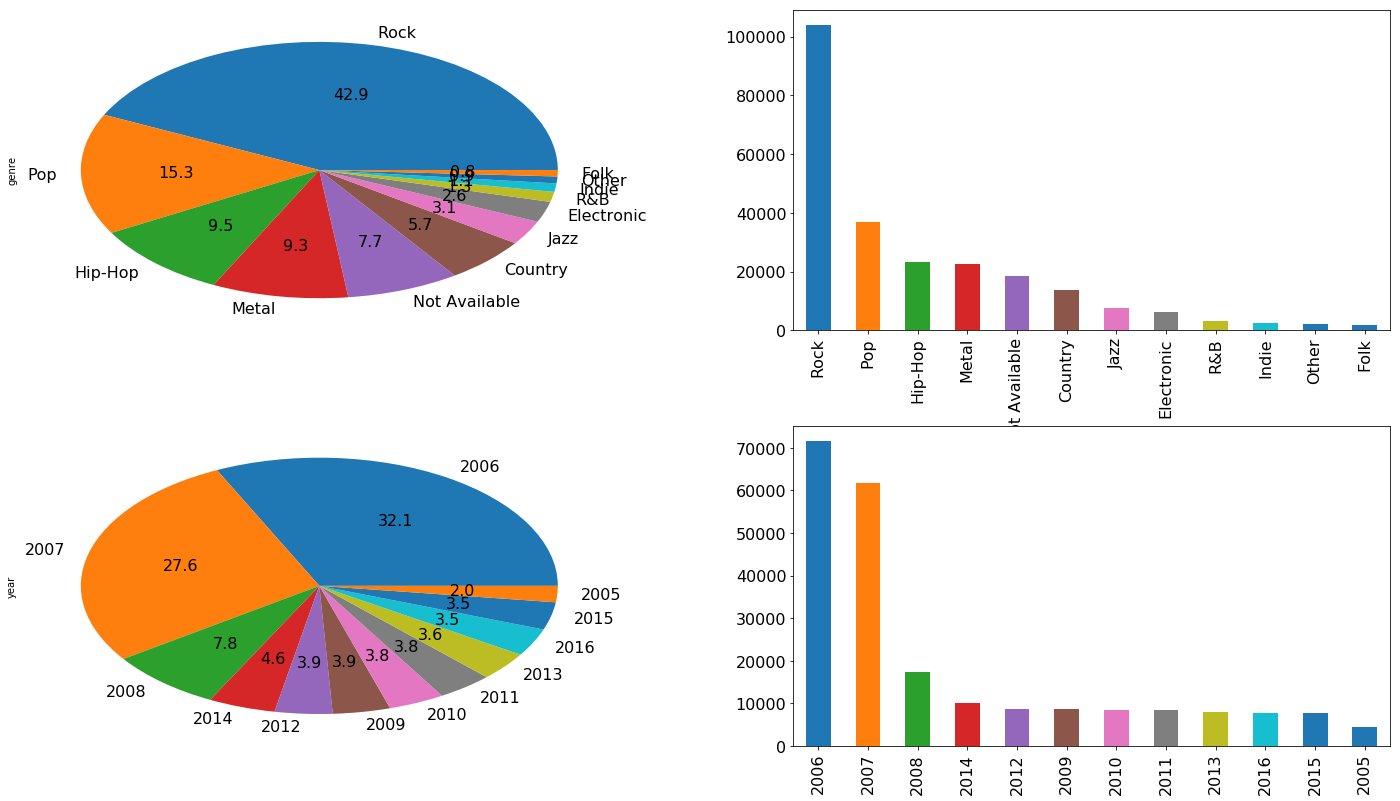

In [79]:
### filtered data where artists had less than 10 songs and where song lyrics had less than 100 words

## looking at updated stats

df = song_df.toPandas()
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

genreCount = df['genre'].value_counts()
yearCount  = df['year'].value_counts().head( 12 )
wordCount = df['word_count'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )

yearCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
yearCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )

#wordCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[1][0], autopct='%.1f' )
#wordCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[1][1] )


print("looking at some artists in sorted order:")
df.sample(n=10).sort_values('artist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb98f372990>]],
      dtype=object)

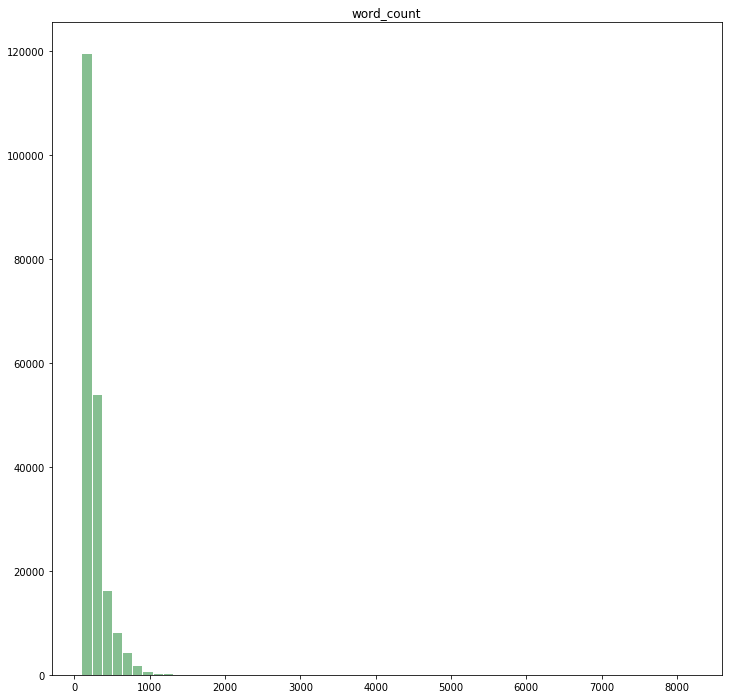

In [28]:
songDF.hist(column='word_count',bins=60, grid=False, figsize=(12,12), color='#86bf91', zorder=2, rwidth=0.9)

In [156]:
print((song_df.count(), len(song_df.columns)))

(204321, 8)


### songs, and artists have been filtered

In [58]:
song_df.describe().show()

+-------+------------------+--------------------+-----------------+------------------+-------+--------------------+------------------+
|summary|             index|                song|             year|            artist|  genre|              lyrics|        word_count|
+-------+------------------+--------------------+-----------------+------------------+-------+--------------------+------------------+
|  count|            229289|              229289|           229289|            229289| 229289|              229289|            229289|
|   mean| 182002.4290698638|3.101596456763466E11|2007.731339052462| 683.0853391684901|   null|                null|254.28280030878062|
| stddev|103949.26554499482|5.599465208038821E12|9.915039634811746|1432.4328217245966|   null|                null|153.00604777827195|
|    min|                 0|                 0-0|              112|  009-sound-system|Country|Where were you w...|             100.0|
|    max|            362236|               zzzzz|      

### we have songs from the year 112.... let us take after 1950

In [13]:
song_df = song_df.filter(song_df.year >= 1950)
song_df.sort('year', ascending = True).show(10)

+------+--------------------+----+-------------+-----+--------------------+----------+---------------+
| index|                song|year|       artist|genre|              lyrics|word_count|number_of_songs|
+------+--------------------+----+-------------+-----+--------------------+----------+---------------+
|124916|         without-you|1968|fleetwood-mac| Rock|I'm crazy for my ...|     107.0|            253|
|314863|     good-vibrations|1970|   beach-boys| Rock|I, I love the col...|     303.0|            410|
|230716|you-re-still-my-w...|1970|     b-b-king| Rock|When I come home ...|     212.0|            487|
|314865|    california-girls|1970|   beach-boys| Rock|Well East coast g...|     219.0|            410|
|230717|      go-underground|1970|     b-b-king| Rock|Yes, you thought ...|     194.0|            487|
|230723|   chains-and-things|1970|     b-b-king| Rock|Woke up this morn...|     177.0|            487|
|314856|      god-only-knows|1970|   beach-boys| Rock|I may not always ..

### stats by genre

In [14]:
songDF = song_df.toPandas()

In [38]:
songDF['word_count'].groupby(songDF['genre']).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,12426.0,197.093755,78.293376,100.0,139.0,179.0,237.0,1366.0
Electronic,4408.0,238.347096,121.318848,100.0,152.0,209.0,288.0,1068.0
Folk,1495.0,218.103679,114.304898,100.0,149.0,194.0,260.0,2393.0
Hip-Hop,22016.0,516.265716,224.004647,100.0,368.0,503.0,642.0,8195.0
Indie,2137.0,220.342536,101.574259,100.0,152.0,199.0,261.0,1050.0
Jazz,5863.0,196.652567,90.497904,100.0,133.0,172.0,233.0,1040.0
Metal,16188.0,207.087905,105.890792,100.0,139.0,181.0,243.0,2423.0
Not Available,14773.0,236.693495,114.946177,100.0,158.0,209.0,283.0,2269.0
Other,1579.0,249.805573,140.503669,100.0,152.0,210.0,303.0,1385.0


### song_df --> spark dataframe
### songDF --> pandas dataframe

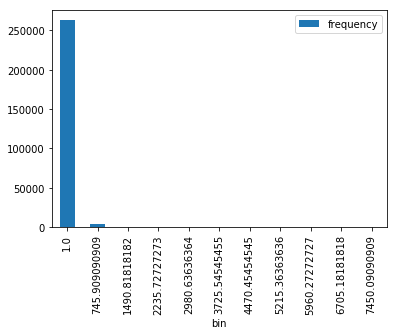

In [40]:
song_df = song_df.select('word_count').rdd.flatMap(lambda x: x).histogram(11)
pd.DataFrame(list(zip(*song_df)), columns=['bin', 'frequency']).set_index('bin').plot(kind='bar')

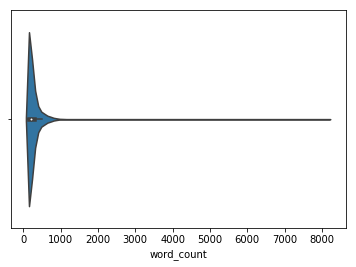

In [23]:
import seaborn as sns
sns.violinplot(x=songDF["word_count"], figsize = (20,12))

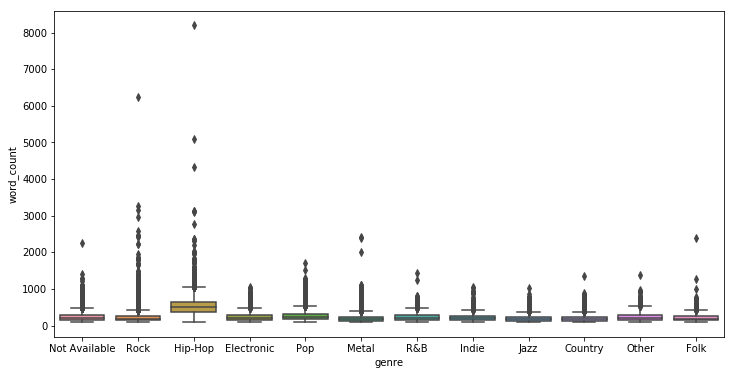

In [25]:
## for a clear picture, let us look at work count by genre
import seaborn as sns
#compare wordcounts by genre
import matplotlib as mpl
mpl.rc("figure", figsize=(12, 6))
sns.boxplot(x="genre", y="word_count", data=songDF)

## looks like hip-hop artists sometimes use a large number of words in their songs.. there are some heavy outliers.. maybe we can remove some songs with too many words

### total unique artists

In [42]:
## by artist
print("we have 4870 unique artists after filtering")
songDF['word_count'].groupby(songDF['artist']).describe()

we have 4870 unique artists after filtering


,count,mean,std,min,25%,50%,75%,max
artist,,,,,,,,
1-girl-nation,10.0,352.700000,75.277339,261.0,292.25,326.5,426.75,466.0
10-cc,142.0,252.732394,84.838429,112.0,197.00,236.5,317.25,592.0
10-years,70.0,190.800000,64.586444,106.0,146.00,179.0,225.25,448.0
100-monkeys,29.0,218.000000,83.228172,102.0,153.00,202.0,257.00,442.0
10000-maniacs,79.0,190.670886,58.044130,112.0,146.50,173.0,218.50,349.0
112,86.0,372.837209,150.155281,106.0,254.25,331.5,472.00,748.0
12-stones,53.0,209.245283,60.423794,109.0,165.00,194.0,248.00,342.0
13-engines,11.0,132.545455,21.593349,101.0,115.50,129.0,146.00,174.0
14-bis,30.0,120.133333,17.395468,101.0,107.00,115.0,132.75,168.0


In [43]:
songDF['number_of_songs'].groupby(songDF['artist']).describe()

,count,mean,std,min,25%,50%,75%,max
artist,,,,,,,,
1-girl-nation,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0
10-cc,142.0,142.0,0.0,142.0,142.0,142.0,142.0,142.0
10-years,70.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
100-monkeys,29.0,29.0,0.0,29.0,29.0,29.0,29.0,29.0
10000-maniacs,79.0,79.0,0.0,79.0,79.0,79.0,79.0,79.0
112,86.0,86.0,0.0,86.0,86.0,86.0,86.0,86.0
12-stones,53.0,53.0,0.0,53.0,53.0,53.0,53.0,53.0
13-engines,11.0,11.0,0.0,11.0,11.0,11.0,11.0,11.0
14-bis,30.0,30.0,0.0,30.0,30.0,30.0,30.0,30.0


### distribution of lyrics

In [44]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with most number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = False).show()

the following are artists with most number of songs, after filtering
+-----------------+---------------+
|           artist|number of songs|
+-----------------+---------------+
|     dolly-parton|            707|
|      chris-brown|            610|
|       elton-john|            607|
|        bob-dylan|            561|
|           eminem|            546|
|         bee-gees|            546|
|    american-idol|            533|
|      celine-dion|            530|
|   elvis-costello|            503|
|      david-bowie|            503|
| barbra-streisand|            502|
|bruce-springsteen|            497|
|         b-b-king|            487|
|      dean-martin|            445|
|  ella-fitzgerald|            444|
|    bill-anderson|            430|
|      eddy-arnold|            426|
|       beach-boys|            410|
|   britney-spears|            393|
|   chamillionaire|            388|
+-----------------+---------------+
only showing top 20 rows



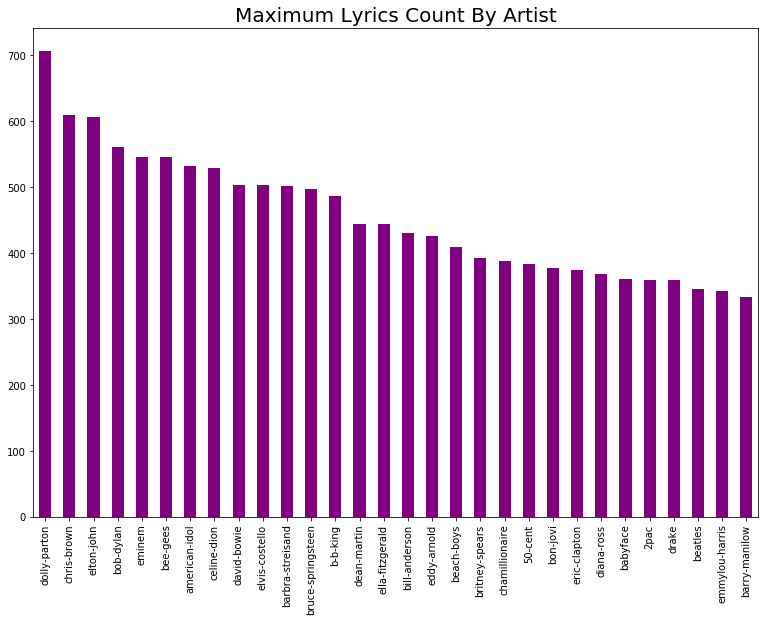

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,9))
plt.title("Maximum Lyrics Count By Artist",fontsize=20)
songDF['artist'].value_counts()[:30].plot('bar',color='purple')

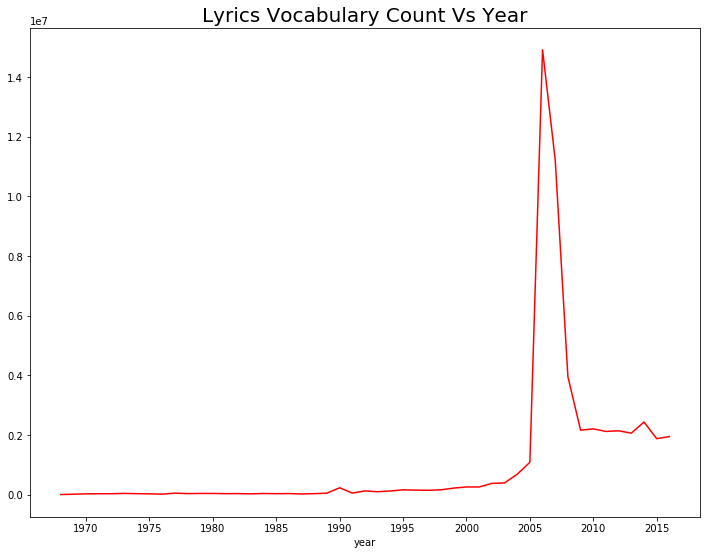

In [50]:
import numpy as np

x = [1970, 1975, 1080, 1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]
Total_year_count = songDF.groupby(['year'])['word_count'].sum()
plt.figure(figsize=(12,9))
plt.xticks(np.arange(min(x), max(x), 5.0))
plt.title("Lyrics Vocabulary Count Vs Year",fontsize=20)
Total_year_count.plot(kind='line',color="Red")

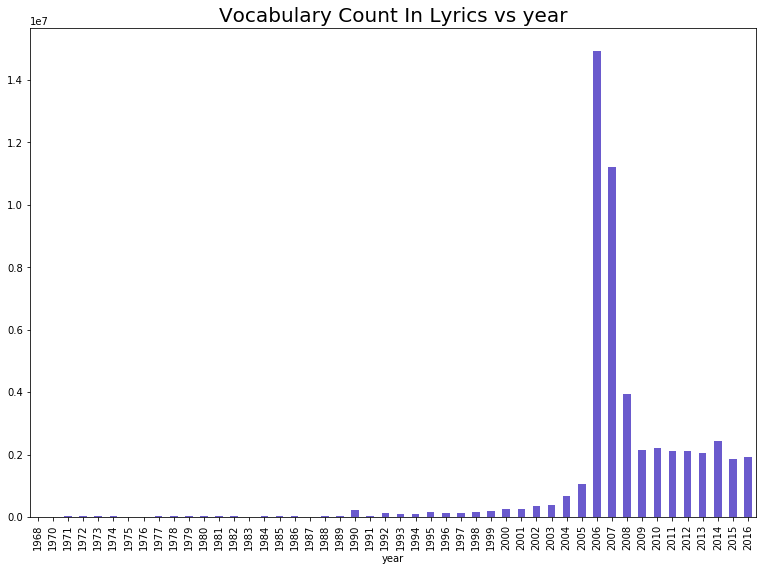

In [51]:
plt.figure(figsize=(13,9))
plt.title("Vocabulary Count In Lyrics vs year",fontsize=20)
Total_year_count.plot(kind='bar',label="Lyrics count vs year",color = 'slateblue')

In [46]:
## artists with max songs , min songs 

import pyspark.sql.functions as f
print("the following are artists with least number of songs, after filtering")
songs = song_df.groupBy('artist').count().select('artist', f.col('count').alias('number of songs')).sort('number of songs', ascending = True).show()

the following are artists with least number of songs, after filtering
+--------------------+---------------+
|              artist|number of songs|
+--------------------+---------------+
|              drapht|             10|
|     fred-eaglesmith|             10|
|andrew-jackson-jihad|             10|
|               damez|             10|
|                daze|             10|
|   caught-in-the-act|             10|
|carrie-hope-fletcher|             10|
|       george-nozuka|             10|
|  eric-michael-jones|             10|
|erik-goes-to-germany|             10|
|     balkan-beat-box|             10|
|        alex-winston|             10|
|               crest|             10|
|         avi-buffalo|             10|
|       38th-parallel|             10|
|      donnie-trumpet|             10|
|      the-blaqk-year|             10|
|    the-black-ghosts|             10|
|                farm|             10|
|          bang-tango|             10|
+--------------------+-----------

### cleaning the data further

In [15]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
import gensim.models.word2vec as w2v
import multiprocessing
import os
import re
import sklearn
import pprint
import seaborn as sns
%matplotlib inline
#stop = stopwords.words('english')

In [16]:
## create tokenizer, remove all the stopwords including \

from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import Tokenizer, RegexTokenizer

In [52]:
#Tokenizer = RegexTokenizer(inputCol="lyrics", outputCol="lyrics_tokenized", pattern= ",")
#cv = CountVectorizer(inputCol="lyrics", outputCol="cv_ingred_sparse", vocabSize=1000000, minDF=2.0)


In [53]:
#regexTokenized_ = Tokenizer.transform(Tokenized_df)

In [54]:
#regexTokenized_.show(2)

In [55]:
#regexTokenized_.select('lyrics_tokenized').rdd.flatMap(list).take(12)

In [56]:
##Tokenizer1 = RegexTokenizer(inputCol="lyrics_tokenized", outputCol="lyrics_tokenized_by_delim", pattern= "'")
#Tokenized_df1 = Tokenizer1.transform(regexTokenized_)
#Tokenized_df1.show(2)

In [57]:
#Tokenized_df1.select('lyrics_tokenized_by_delim').rdd.flatMap(list).take(12)

In [37]:
#Tokenizer2 = RegexTokenizer(inputCol="lyrics", outputCol="lyrics_tokenized_by_backslash", pattern= "/")
#Tokenized_df2 = Tokenizer2.transform(Tokenized_df1)
#Tokenized_df2.show(2)

In [39]:
# count number of lines
songDF['lines'] = songDF['lyrics'].map(lambda t: len(re.findall(r'/', t)))
songDF.head()
print ("there are {} / kind of characters in the column lyrics" .format(sum(songDF['lines'])))
# remove line breaks


there are 13223 / kind of characters in the column lyrics


### removing '/', ' '
### to remove ' ', we use /W+

In [17]:
songDF['lyrics'] = songDF['lyrics'].map(lambda s: re.sub(r' /|/', '', s))
#songDF['lyrics'] = songDF['lyrics'].map(lambda s: re.sub(r '!()-[]{};:\,<>./?@#$%^&*_', '', s))

In [18]:
# count number of lines
songDF['lines'] = songDF['lyrics'].map(lambda t: len(re.findall(r'/', t)))
songDF.head()
print ("there are {} / kind of characters in the column lyrics" .format(sum(songDF['lines'])))
# remove line breaks

there are 0 / kind of characters in the column lyrics


In [19]:
# count number of lines
songDF['this'] = songDF['lyrics'].map(lambda t: len(re.findall(r' ''', t)))
songDF.head()
print ("there are {} kind of characters in the column lyrics" .format(sum(songDF['this'])))
# remove ''

there are 47974905 kind of characters in the column lyrics


In [20]:
songDF['lyrics_cleaned'] = songDF['lyrics'].map(lambda s: re.sub(r'\W+',' ', s))

In [49]:
#songDF['result'] = songDF['lyrics'].map(lambda x: x.lstrip(' '' ').rstrip(''))

In [21]:
songDF

,index,song,year,artist,genre,lyrics,word_count,number_of_songs,lines,lyrics_cleaned
0,198081,1-girl-nation,2014,1-girl-nation,Not Available,"Hey, there's a girl sittin' all alone Heartbro...",312.0,10,0,Hey there s a girl sittin all alone Heartbroke...
1,198073,cinema,2016,1-girl-nation,Not Available,Girls night out at the movies Grab some popcor...,441.0,10,0,Girls night out at the movies Grab some popcor...
2,198075,get-hype,2016,1-girl-nation,Not Available,Go crazy Crazy Crazy Crazy is my middle name W...,466.0,10,0,Go crazy Crazy Crazy Crazy is my middle name W...
3,198074,guard-your-heart,2016,1-girl-nation,Not Available,"In the middle of this crazy, messed up world w...",290.0,10,0,In the middle of this crazy messed up world we...
4,198076,haters,2016,1-girl-nation,Not Available,It's been three hours Staring at the screen Re...,341.0,10,0,It s been three hours Staring at the screen Re...
5,198077,impossible,2016,1-girl-nation,Not Available,I guess I've always been a dreamer But today n...,299.0,10,0,I guess I ve always been a dreamer But today n...
6,198078,nofilter,2016,1-girl-nation,Not Available,"This, this is me, this is me This is, this is ...",438.0,10,0,This this is me this is me This is this is me ...
7,198072,panic,2016,1-girl-nation,Not Available,"Panic Panic Panic If I'm really honest, I'd sa...",286.0,10,0,Panic Panic Panic If I m really honest I d say...
8,198079,try-cover,2014,1-girl-nation,Not Available,Put your make-up on Get your nails done Curl y...,393.0,10,0,Put your make up on Get your nails done Curl y...
9,198071,while-we-re-young,2013,1-girl-nation,Not Available,We've all heard people talking about all the t...,261.0,10,0,We ve all heard people talking about all the t...


In [21]:
# count number of lines
songDF['this'] = songDF['lyrics_cleaned'].map(lambda t: len(re.findall(r'\W+', t)))
songDF.head()
print ("there are {} kind of characters in the column lyrics" .format(sum(songDF['this'])))
# remove ''

there are 50642552 kind of characters in the column lyrics


In [22]:
songDF['newLines'] = songDF['lyrics'].map(lambda t: len(re.findall(r'\n', t)))
songDF.head()

,index,song,year,artist,genre,lyrics,word_count,number_of_songs,lines,this,lyrics_cleaned,newLines
0,238147,24-hours,2006,10-cc,Rock,Here on the street Feeling the cool of the daw...,356.0,142,0,374,Here on the street Feeling the cool of the daw...,0
1,238097,action-man-in-a-motown-suit,2006,10-cc,Rock,Let's stay a while and watch him He's moving i...,261.0,142,0,286,Let s stay a while and watch him He s moving i...,0
2,238176,age-of-consent,1995,10-cc,Rock,I want to meet you at that restaurant The one ...,263.0,142,0,277,I want to meet you at that restaurant The one ...,0
3,238127,american-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,0,220,Martin Luther B B King You had a dream and you...,0
4,238132,americana-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,0,220,Martin Luther B B King You had a dream and you...,0


In [23]:
songDF = songDF.drop(columns = ['newLines'], axis = 1)
songDF = songDF.drop(columns = ['lines'], axis = 1)
songDF = songDF.drop(columns = ['this'], axis = 1)
#songDF = songDF.drop(columns = ['result'], axis = 1)

In [31]:
songDF.head()

,index,song,year,artist,genre,lyrics,word_count,number_of_songs,lyrics_cleaned
0,238147,24-hours,2006,10-cc,Rock,Here on the street Feeling the cool of the daw...,356.0,142,Here on the street Feeling the cool of the daw...
1,238097,action-man-in-a-motown-suit,2006,10-cc,Rock,Let's stay a while and watch him He's moving i...,261.0,142,Let s stay a while and watch him He s moving i...
2,238176,age-of-consent,1995,10-cc,Rock,I want to meet you at that restaurant The one ...,263.0,142,I want to meet you at that restaurant The one ...
3,238127,american-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,Martin Luther B B King You had a dream and you...
4,238132,americana-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,Martin Luther B B King You had a dream and you...


### only english songs

In [65]:
#python -m pip install textblob

In [74]:
import os
import sys
import pip
#sys.path.append('C:\Users\lenovo\Documents\Langdetect\langdetect-1.0.7\langdetect')

In [76]:
#import pip
#!pip install --upgrade pip

Traceback (most recent call last):
  File "/usr/local/bin/pip", line 7, in <module>
    from pip._internal import main
ImportError: No module named 'pip._internal'


In [67]:
!python -m pip install --user --upgrade pip

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Requirement already up-to-date: pip in /home/srs418/.local/lib/python2.7/site-packages (19.3.1)


In [163]:
! python -m pip install langdetect

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support


In [154]:
! export PYTHONPATH="/home/srs418/.local/lib/python2.7/site-packages"

In [159]:
import sys
for d in sys.path:
    print d

/opt/spark-2.2.0-bin-hadoop2.7/python
/tmp/spark-b2d43fcc-9600-4007-81d8-7c98b34bbe0e/userFiles-17d97b4e-d2c8-40bd-af58-5a14491287ba
/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip

/home/srs418/ISE_467/Project 2
/home/software/lib/python2.6/dist-packages
/usr/lib/python2.7
/usr/lib/python2.7/plat-x86_64-linux-gnu
/usr/lib/python2.7/lib-tk
/usr/lib/python2.7/lib-old
/usr/lib/python2.7/lib-dynload
/usr/local/lib/python2.7/dist-packages
/usr/local/lib/python2.7/dist-packages/seq2seq-0.1.0-py2.7.egg
/usr/local/lib/python2.7/dist-packages/Keras-2.0.4-py2.7.egg
/usr/local/lib/python2.7/dist-packages/recurrentshop-1.0.0-py2.7.egg
/usr/lib/python2.7/dist-packages
/usr/lib/python2.7/dist-packages/PILcompat
/usr/lib/python2.7/dist-packages/gst-0.10
/usr/lib/python2.7/dist-packages/gtk-2.0
/usr/lib/pymodules/python2.7
/usr/local/lib/python2.7/dist-packages/IPython/extensions
/home/srs418/.ipython


In [70]:
import sys
sys.path
sys.path.append('/home/srs418/.local/lib/python2.7/site-packages')
sys.path.append('/usr/local/lib/python2.7/dist-packages')
sys.path.append('/usr/local/bin/pip')
print(sys.path)

['/opt/spark-2.2.0-bin-hadoop2.7/python', u'/tmp/spark-c4956c5c-a857-4252-ba3f-ecf8e4f78f8f/userFiles-3bcdc0ae-aab2-4bae-909e-e8dda82a6683', '/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip', '', '/home/srs418/ISE_467/Project 2', '/home/software/lib/python2.6/dist-packages', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/srs418/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/local/lib/python2.7/dist-packages/seq2seq-0.1.0-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/Keras-2.0.4-py2.7.egg', '/usr/local/lib/python2.7/dist-packages/recurrentshop-1.0.0-py2.7.egg', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gst-0.10', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7', '/usr/local/lib/python2.7/dist-packages/IPython/exten

In [84]:
! python -m pip install textblob --user

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
  Using cached https://files.pythonhosted.org/packages/60/f0/1d9bfcc8ee6b83472ec571406bd0dd51c0e6330ff1a51b2d29861d389e85/textblob-0.15.3-py2.py3-none-any.whl


### from here

In [24]:
import langdetect
import textblob

In [25]:
from langdetect import detect_langs
from langdetect import detect

In [26]:
from scipy import sparse
from scipy.sparse import csr_matrix, vstack
#from textblob import TextBlob
from langdetect import detect_langs
from langdetect import detect
import pickle
from datetime import datetime

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [28]:
detect_langs('Hey, theres a girl sittin')

[en:0.999996032118]

In [29]:
def get_eng_prob(lyrics):
    detections = detect_langs(lyrics)
    for detection in detections:
        if detection.lang == 'en':
            return detection.prob
        return 0


#print('Number of english songs: {}'.format(sum(songDF['en_prob'] >= 0.5)))
#print('Number of non-english songs: {}'.format(sum(songDF['en_prob'] < 0.5)))

In [32]:
get_eng_prob('what is uppp')

0.9999961661864212

In [ ]:
songDF['en_prob'] = songDF['lyrics'].map(get_eng_prob)

In [25]:
songDF = songDF.loc[songDF['en_prob'] >= 0.5]

KeyError: 'en_prob'

### Required operations:

### 1. Clearing text from punctuation (regexp_replace)
### 2. Tokenization (Tokenizer)
### 3. Delete stop words (StopWordsRemover)
### 4. Stemming (SnowballStemmer)
### 5.Filtering short words (udf)
### 6. countVectorizer
### 7. hashinTF
### 8. dealing with (), [] in lyrics

In [27]:
# remove round brackets but not text within
songDF['lyrics_cleaned'] = songDF['lyrics_cleaned'].map(lambda s: re.sub(r'\(|\)', '', s))

In [28]:
# remove square brackets and text within
songDF['lyrics_cleaned'] = songDF['lyrics_cleaned'].map(lambda s: re.sub(r'\[(.*?)\]', '', s))

In [29]:
# remove square brackets and not text within
songDF['lyrics_cleaned'] = songDF['lyrics_cleaned'].map(lambda s: re.sub(r'\{|\} ', '', s))

In [22]:
text_in_round_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

Number of round brackets: 0


In [23]:
text_in_square_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\[(.*?)\]',s))), [])
print('Number of square brackets: {}'.format(len(text_in_square_brackets)))

Number of square brackets: 0


In [24]:
text_in_curly_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\{(.*?)\}',s))), [])
print('Number of curly brackets: {}'.format(len(text_in_curly_brackets)))

Number of curly brackets: 0


### after reducing words

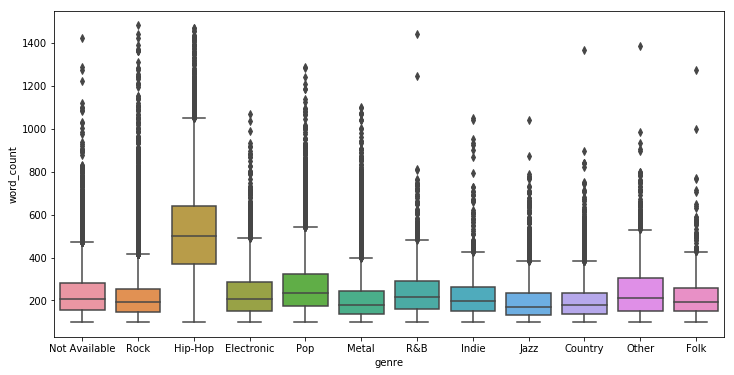

In [45]:
import matplotlib as mpl
mpl.rc("figure", figsize=(12, 6))
sns.boxplot(x="genre", y="word_count", data=songDF)

In [47]:
genre = songDF.groupby(['genre'],as_index=False).count()
genre2 = genre[['genre','song']]
genre2

,genre,song
0,Country,12426
1,Electronic,4408
2,Folk,1494
3,Hip-Hop,21977
4,Indie,2137
5,Jazz,5863
6,Metal,16185
7,Not Available,14772
8,Other,1579
9,Pop,33738


In [30]:
songNewDF = ss.createDataFrame(songDF)

In [37]:
songNewDF.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+
only showing top 2 rows



In [31]:
#Tokenized_df2.select('lyrics_tokenized_by_backslash').rdd.flatMap(list).take(12)

from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkContext

Tokenizer = RegexTokenizer(inputCol="lyrics_cleaned", outputCol="all_lyrics_tokenized_", pattern= " ")
Tokenized_df = Tokenizer.transform(songNewDF)
Tokenized_df.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|all_lyrics_tokenized_|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...| [here, on, the, s...|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...| [let, s, stay, a,...|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+
only showing top 2 rows



In [28]:
#Tokenizer = RegexTokenizer(inputCol="lyrics", outputCol="all_lyrics_tokenized_", pattern= " ")
#hashtf = HashingTF(numFeatures=2**16, inputCol="lyrics", outputCol='tf')
#Tokenized_df = Tokenizer.transform(song_df)
#Tokenized_df.show(2)

In [29]:
#Tokenizer = RegexTokenizer(inputCol="lyrics_cleaned", outputCol="all_lyrics_tokenized_", pattern= " ")
#Tokenized_df = Tokenizer.transform(songNewDF)
#Tokenized_df.show(2)

+------+-------------+----+-------------+-------------+--------------------+----------+---------------+---------------------+
| index|         song|year|       artist|        genre|              lyrics|word_count|number_of_songs|all_lyrics_tokenized_|
+------+-------------+----+-------------+-------------+--------------------+----------+---------------+---------------------+
|198081|1-girl-nation|2014|1-girl-nation|Not Available|Hey, there's a gi...|     312.0|             10| [hey,, there's, a...|
|198073|       cinema|2016|1-girl-nation|Not Available|Girls night out a...|     441.0|             10| [girls, night, ou...|
+------+-------------+----+-------------+-------------+--------------------+----------+---------------+---------------------+
only showing top 2 rows



In [54]:
Tokenized_df.select('lyrics_cleaned').show(10)

+--------------------+
|      lyrics_cleaned|
+--------------------+
|Hey there s a gir...|
|Girls night out a...|
|Go crazy Crazy Cr...|
|In the middle of ...|
|It s been three h...|
|I guess I ve alwa...|
|This this is me t...|
|Panic Panic Panic...|
|Put your make up ...|
|We ve all heard p...|
+--------------------+
only showing top 10 rows



In [32]:
from pyspark.sql.functions import regexp_replace

Tokenized_df = Tokenized_df.withColumn('song_name', regexp_replace('song', '-', ' '))
#Tokenized_df = Tokenized_df.withColumn('song_name', regexp_replace('lyrics', '', ' '))
Tokenized_df.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|all_lyrics_tokenized_|           song_name|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...| [here, on, the, s...|            24 hours|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...| [let, s, stay, a,...|action man in a m...|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+
only showing top 2 rows



In [33]:
from pyspark.sql.functions import regexp_replace

Tokenized_df = Tokenized_df.withColumn('artist_name', regexp_replace('artist', '-', ' '))
#Tokenized_df = Tokenized_df.withColumn('song_name', regexp_replace('lyrics', '', ' '))
Tokenized_df.show(2)

+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+-----------+
| index|                song|year|artist|genre|              lyrics|word_count|number_of_songs|      lyrics_cleaned|all_lyrics_tokenized_|           song_name|artist_name|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--------------------+-----------+
|238147|            24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142|Here on the stree...| [here, on, the, s...|            24 hours|      10 cc|
|238097|action-man-in-a-m...|2006| 10-cc| Rock|Let's stay a whil...|     261.0|            142|Let s stay a whil...| [let, s, stay, a,...|action man in a m...|      10 cc|
+------+--------------------+----+------+-----+--------------------+----------+---------------+--------------------+---------------------+--

In [26]:
#from pyspark.sql.functions import concat_ws
#Tokenized_df = Tokenized_df.withColumn("song_name_",concat_ws(",","song_name"))  #converts array(string) --> list
#Tokenized_df.show(2)

In [27]:
#from pyspark.sql.functions import regexp_replace

#tdf = Tokenized_df.withColumn('name', regexp_replace('song_name_', ',', ' '))
#tdf.show(2)

In [29]:
Tokenized_df.select('song_name').rdd.flatMap(list).take(10)

[u'1 girl nation',
 u'cinema',
 u'get hype',
 u'guard your heart',
 u'haters',
 u'impossible',
 u'nofilter',
 u'panic',
 u'try cover',
 u'while we re young']

In [ ]:
#mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=3)
#model = mh.fit(dfassembler1)
#model.transform(dfassembler1).show(3, False)

In [52]:
Tokenized_df.select('all_lyrics_tokenized_').rdd.flatMap(list).take(1)

[[u'hey',
  u'there',
  u's',
  u'a',
  u'girl',
  u'sittin',
  u'all',
  u'alone',
  u'heartbroke',
  u'and',
  u'i',
  u'bet',
  u'you',
  u'didn',
  u't',
  u'even',
  u'know',
  u'you',
  u're',
  u'there',
  u'messin',
  u'with',
  u'your',
  u'hair',
  u'you',
  u'ain',
  u't',
  u'got',
  u'time',
  u'and',
  u'you',
  u'just',
  u'don',
  u't',
  u'care',
  u'what',
  u's',
  u'up',
  u'with',
  u'the',
  u'he',
  u'said',
  u'she',
  u'said',
  u'drama',
  u'drama',
  u'talkin',
  u'smack',
  u'on',
  u'the',
  u'internet',
  u'sister',
  u'she',
  u's',
  u'just',
  u'like',
  u'you',
  u'so',
  u'don',
  u't',
  u'talk',
  u'trash',
  u'cause',
  u'i',
  u've',
  u'been',
  u'there',
  u'too',
  u'it',
  u's',
  u'time',
  u'for',
  u'a',
  u'little',
  u'less',
  u'talk',
  u'a',
  u'little',
  u'less',
  u'talk',
  u'cause',
  u'we',
  u'all',
  u'got',
  u'faults',
  u'it',
  u's',
  u'time',
  u'for',
  u'a',
  u'little',
  u'less',
  u'talk',
  u'a',
  u'little',
  u'le

In [27]:
print((Tokenized_df.count(), len(Tokenized_df.columns)))

(204316, 12)


In [ ]:
#from pyspark.sql.functions import udf, col, lower, regexp_replace
#from pyspark.ml.feature import Tokenizer, StopWordsRemover
#from nltk.stem.snowball import SnowballStemmer

# Clean text
#df_clean = Tokenized_df.select('tokeniz', (lower(regexp_replace('text', "[^a-zA-Z\\s]", "")).alias('text')))

# Tokenize text
#tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
#df_words_token = tokenizer.transform(df_clean).select('id', 'words_token')

# Remove stop words
#remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
#df_words_no_stopw = remover.transform(df_words_token).select('id', 'words_clean')

# Stem text
#stemmer = SnowballStemmer(language='english')
#stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
#df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('id', 'words_stemmed')

# Filter length word > 3
#filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
#df_final_words = df_stemmed.withColumn('words', filter_length_udf(col('words_stemmed')))

In [24]:
#from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml import Pipeline

#tokenizer = Tokenizer(inputCol="lyrics", outputCol="lyrics_tokenized")
#hashtf = HashingTF(numFeatures=2**16, inputCol="lyrics", outputCol='tf')
#idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
##label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
#pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

#pipelineFit = pipeline.fit(train_set)
#_df = pipeline.fit(song_df)
#val_df = pipelineFit.transform(val_set)
#_df.show(5)

### data cleaning and tokenizing is now done... stop words should be next
### Tokenized_df --> spark dataframe, tokenized_panda --> pandas dataframe

### Required operations:

### 1. Clearing text from punctuation (regexp_replace)
### 2. Tokenization (Tokenizer)
### 3. Delete stop words (StopWordsRemover)
### 4. Stematization (SnowballStemmer)
### 5.Filtering short words (udf)
### 6. countVectorizer
### 7. hashinTF
### 8. dealing with (), [] in lyrics

In [ ]:
#Tasks:

#Number of artists
#Which artist has highest and lowest number of songs
#Distribution of songs of all artists in the dataset
#Distribution of lyrics length
#Which song lyrics has maximum number of words
#Which song lyrics has minimum number of words
#Distribution of words count in title
#Which songs title has maximum number of words
#Which songs title has minimum number of words
#WordClouds of titles with minimum and maximum lengths
#Is there a relation between title length and song length?
#Sentiments of the songs (NRC, Bing)
#Which words are most occuring in the lyrics of the songs
#Wordcloud of most popular words in the songs
#Top words used by an artist in his/her songs
#Are there some common Rythmic words that repeats again and again?

In [23]:
#import nltk
#not used

def clean_text(text):
    text = text.replace('--', ' ')
    text = text.replace('\t', ' ')
    tokens = text.split()
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word.lower() for word in tokens if word not in nltk.corpus.stopwords.words('english')]
    return tokens

In [24]:
#not used
def gen_data(rows):
    lyrics_data = pd.read_csv('/scratch/ISE495/2019_project_data/group-7/lyrics.csv')
    print("No of rows in data are %s",lyrics_data.__len__())
    lyrics_data = lyrics_data[pd.notnull(lyrics_data['lyrics'])]
    if rows<lyrics_data.__len__(): 
        lyrics_data_sample = lyrics_data[0:rows]
        lyrics_data_sample['lyrics'] = lyrics_data_sample['lyrics'].apply(lambda x: clean_text(x))
    else:
        print("Rows exceeded")
    return lyrics_data_sample

In [44]:
songDF['lyrics'].iloc[149799]

u'[Eazy-E] Yo Dre where\'s the goddamn drum machine? [Dre] Aw shit I left the muthafucka with Poog [Eazy-E] You dumb muthafucka what the fuck we gonna do now? [Yella] Hey, man I got some drums in the back [Dre] Man what the fuck is he talkin\' bout [M.C. Ren] Yo does it look like we can play some fuckin\' drums? [Yella] Man I can play the drums [Everyone except Yella] Bullshit! [Yella] Man I used to fuck it up at Compton [*Arguin\'*] [M.C. Ren] Give this nigga some sticks.... Yo Fuck it up Yella [M.C. Ren] Yo were two hard muthafuckaz takin\' out any punk ass suckaz can you believe this or so be frightened were strong as fuck, with the power of a titan settin\' a mark of destruction get it so don\'t front, and say you ain\'t with it you wanna rumble with us you can\'t hang cause were something like a two man gang start some shit is what we do best scared by the suckaz say fuck the rest so yo Eazy bust it and shoot to kill and tell these stupid muthafuckaz the deal [Eazy-E] I look you d

In [43]:
songDF['lyrics_cleaned'].iloc[149799]

u' Eazy E Yo Dre where s the goddamn drum machine Dre Aw shit I left the muthafucka with Poog Eazy E You dumb muthafucka what the fuck we gonna do now Yella Hey man I got some drums in the back Dre Man what the fuck is he talkin bout M C Ren Yo does it look like we can play some fuckin drums Yella Man I can play the drums Everyone except Yella Bullshit Yella Man I used to fuck it up at Compton Arguin M C Ren Give this nigga some sticks Yo Fuck it up Yella M C Ren Yo were two hard muthafuckaz takin out any punk ass suckaz can you believe this or so be frightened were strong as fuck with the power of a titan settin a mark of destruction get it so don t front and say you ain t with it you wanna rumble with us you can t hang cause were something like a two man gang start some shit is what we do best scared by the suckaz say fuck the rest so yo Eazy bust it and shoot to kill and tell these stupid muthafuckaz the deal Eazy E I look you dead in the eye and I spit tell you to your face punk yo

In [49]:
Tokenized_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = true)
 |-- lyrics_cleaned: string (nullable = true)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- song_name: string (nullable = true)



In [34]:
songDF1 = Tokenized_df.toPandas()
songDF1.head()

,index,song,year,artist,genre,lyrics,word_count,number_of_songs,lyrics_cleaned,all_lyrics_tokenized_,song_name,artist_name
0,238147,24-hours,2006,10-cc,Rock,Here on the street Feeling the cool of the daw...,356.0,142,Here on the street Feeling the cool of the daw...,"[here, on, the, street, feeling, the, cool, of...",24 hours,10 cc
1,238097,action-man-in-a-motown-suit,2006,10-cc,Rock,Let's stay a while and watch him He's moving i...,261.0,142,Let s stay a while and watch him He s moving i...,"[let, s, stay, a, while, and, watch, him, he, ...",action man in a motown suit,10 cc
2,238176,age-of-consent,1995,10-cc,Rock,I want to meet you at that restaurant The one ...,263.0,142,I want to meet you at that restaurant The one ...,"[i, want, to, meet, you, at, that, restaurant,...",age of consent,10 cc
3,238127,american-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,Martin Luther B B King You had a dream and you...,"[martin, luther, b, b, king, you, had, a, drea...",american panorama,10 cc
4,238132,americana-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,Martin Luther B B King You had a dream and you...,"[martin, luther, b, b, king, you, had, a, drea...",americana panorama,10 cc


In [ ]:
#### selecting rows based on column values in python

#df.loc[df['column_name'].isin(some_values)]
#Combine multiple conditions with &:

#df.loc[(df['column_name'] >= A) & (df['column_name'] <= B)]
#Note the parentheses. Due to Python's operator precedence rules, & binds more tightly than <= and >=. Thus, the parentheses in the last example are necessary. Without the parentheses

#df['column_name'] >= A & df['column_name'] <= B
#is parsed as

#df['column_name'] >= (A & df['column_name']) <= B
#which results in a Truth value of a Series is ambiguous error.

#To select rows whose column value does not equal some_value, use !=:

#df.loc[df['column_name'] != some_value]
#isin returns a boolean Series, so to select rows whose value is not in some_values, negate the boolean Series using ~:

#df.loc[~df['column_name'].isin(some_values)]

#selecting rows based on column values in pyspark

#result = users_df.where(users_df._id == chosen_user).select("gender")
#or with col

#from pyspark.sql.functions import col

#result = users_df.where(col("_id") == chosen_user).select(col("gender"))
#Finally PySpark Row is just a tuple with some extensions so you can for example flatMap:

#result.rdd.flatMap(list).first()
#or map with something like this:

#result.rdd.map(lambda x: x.gender).first()

In [41]:
print(songDF.loc[songDF['artist'] == 'eazy-e'])#.iloc[301]

        index                                 song  year  artist    genre  \
149799    315                       2-hard-mutha-s  2002  eazy-e  Hip-Hop   
149800    299                     24-hours-to-live  2006  eazy-e  Hip-Hop   
149801    285                               8-ball  2006  eazy-e  Hip-Hop   
149802    250                         8-ball-remix  2007  eazy-e  Hip-Hop   
149803    269                       any-last-werdz  1998  eazy-e  Hip-Hop   
149804    296                       any-last-wordz  2006  eazy-e  Hip-Hop   
149805    330                           automobile  1995  eazy-e  Hip-Hop   
149806    253                           automoblie  2007  eazy-e  Hip-Hop   
149807    284                    black-nigga-killa  2006  eazy-e  Hip-Hop   
149808    252                      boyz-in-da-hood  2007  eazy-e  Hip-Hop   
149809    255               boyz-in-the-hood-remix  2007  eazy-e  Hip-Hop   
149810    291                boyz-n-tha-hood-g-mix  2006  eazy-e  Hip-Hop   

In [48]:
print(songDF.loc[songDF['genre'] == 'Hip-Hop'])#.iloc[301]

         index                                            song  year  \
330     361181                                       112-intro  2006   
331     361144                                   all-cried-out  2006   
332     361126                               all-i-want-is-you  2006   
333     361168                                     all-my-love  2006   
334     361130                                        anything  2006   
335     361155                                        anywhere  2006   
336     361154                                  anywhere-remix  2006   
337     361127                                     be-with-you  2006   
338     361165                                    call-my-name  2006   
339     361140                                 can-i-touch-you  2006   
340     361179                                       caught-up  2006   
341     361106                                closing-the-club  2005   
342     361182                                     come-see-me  

In [55]:
result = Tokenized_df.where(Tokenized_df.artist == "eazy-e").select("lyrics")
result.rdd.flatMap(list).take(1)

[u'Yo Dre where\'s the goddamn drum machine? Aw shit I left the muthafucka with Poog You dumb muthafucka what the fuck we gonna do now? Hey, man I got some drums in the back Man what the fuck is he talkin\' bout Yo does it look like we can play some fuckin\' drums? Man I can play the drums Bullshit! Man I used to fuck it up at Compton Give this nigga some sticks.... Yo Fuck it up Yella Yo were two hard muthafuckaz takin\' out any punk ass suckaz can you believe this or so be frightened were strong as fuck, with the power of a titan settin\' a mark of destruction get it so don\'t front, and say you ain\'t with it you wanna rumble with us you can\'t hang cause were something like a two man gang start some shit is what we do best scared by the suckaz say fuck the rest so yo Eazy bust it and shoot to kill and tell these stupid muthafuckaz the deal I look you dead in the eye and I spit tell you to your face punk you ain\'t shit I don\'t give a goddamn about feelin\'s I\'m just as a happy as

### dealing with stopwords

In [58]:
#import nltk
#from nltk.corpus import stopwords
#from nltk.probability import FreqDist
#import seaborn as sns
#nltk.download('stopwords')


#customStopWords = ["'s", "n't", "'m", "'re", "'ll","'ve","...", "ä±", "''", '``',\
                  #'--', "'d", 'el', 'la']
#stopWords = stopwords.words('english') + customStopWords

#words = ""
#for song in songDF.iterrows():
#    words += " " + song[1]['lyrics']

#words = nltk.word_tokenize( words.lower() )
#words = [ word for word in words if len(word) > 1\
                             #and not word.isnumeric()\
                             #and word not in stopWords ]
    
#word_dist = FreqDist( words  )
#print("The 10 most common words in the dataset are :")
#for word, frequency in word_dist.most_common(10):
#    print( u'{} : {}'.format( word, frequency ) )

#plt.figure(figsize=(15, 10))
#nlp_words = word_dist.plot( 20 )

In [36]:
songs_rdd = Tokenized_df.select("lyrics_cleaned").rdd.flatMap(lambda x: x)
songs_rdd = songs_rdd.map(lambda x : x.lower())
songs_rdd.take(2)

[u'here on the street feeling the cool of the dawn shuffling feet faces are ragged and worn they ve been working all night waiting for the curtain to rise while you re under the sheets you with the stars in your eyes letter box noise snapping the day into life newspaper boys cutting the mist like a knife we re beginning to rise curtain up the drama begins it s the start of the race all of us wanting to win people rushing shouting pushing got no time for conversation inner city population the struggle for communication people trying pressure rising hook and hustle flex your muscle it s all part of living do you want to get away restaurant smells mix in the heat of the day telephone bells kissogram girls on her way someone s thinking of you birthday boy is in for a treat and the message is clear once a year life can be sweet caught in a flash cover girl freezes her smile media trash blinding the crowd with such style it s a dazzling affair a fantasy to star in your dreams do you want to 

### all punctutations are removed

In [40]:
words = Tokenized_df.select('all_lyrics_tokenized_').rdd
words.take(1)

[Row(all_lyrics_tokenized_=[u'here', u'on', u'the', u'street', u'feeling', u'the', u'cool', u'of', u'the', u'dawn', u'shuffling', u'feet', u'faces', u'are', u'ragged', u'and', u'worn', u'they', u've', u'been', u'working', u'all', u'night', u'waiting', u'for', u'the', u'curtain', u'to', u'rise', u'while', u'you', u're', u'under', u'the', u'sheets', u'you', u'with', u'the', u'stars', u'in', u'your', u'eyes', u'letter', u'box', u'noise', u'snapping', u'the', u'day', u'into', u'life', u'newspaper', u'boys', u'cutting', u'the', u'mist', u'like', u'a', u'knife', u'we', u're', u'beginning', u'to', u'rise', u'curtain', u'up', u'the', u'drama', u'begins', u'it', u's', u'the', u'start', u'of', u'the', u'race', u'all', u'of', u'us', u'wanting', u'to', u'win', u'people', u'rushing', u'shouting', u'pushing', u'got', u'no', u'time', u'for', u'conversation', u'inner', u'city', u'population', u'the', u'struggle', u'for', u'communication', u'people', u'trying', u'pressure', u'rising', u'hook', u'and', 

In [27]:
Tokenized_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = false)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- song_name: string (nullable = true)



In [59]:
#from pyspark.ml.feature import HashingTF, IDF, Tokenizer
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml import Pipeline

#tokenizer = Tokenizer(inputCol="lyrics", outputCol="lyrics_tokenized")
#hashtf = HashingTF(numFeatures=2**16, inputCol="lyrics", outputCol='tf')
#idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
#label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
#pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

#pipelineFit = pipeline.fit(train_set)
#train_df = pipelineFit.transform(train_set)
#val_df = pipelineFit.transform(val_set)


In [43]:
Tokenized_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = true)
 |-- lyrics_cleaned: string (nullable = true)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- song_name: string (nullable = true)



In [33]:
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import udf, col, lower, regexp_replace
#from pyspark.ml.feature import Tokenizer, StopWordsRemover
#from nltk.stem.snowball import SnowballStemmer

# Tokenize text
#tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
#df_words_token = tokenizer.transform(df_clean).select('id', 'words_token')

# Remove stop words
#remover = StopWordsRemover(inputCol='all_lyrics_tokenized_', outputCol='words_clean')
#df_words_no_stopw = remover.transform(Tokenized_df).select('index''artist', 'words_clean')

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, lower, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from nltk.stem.snowball import SnowballStemmer

# Tokenize text
#tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
#df_words_token = tokenizer.transform(df_clean).select('id', 'words_token')

# Remove stop words
remover = StopWordsRemover(inputCol='all_lyrics_tokenized_', outputCol='words_clean')
df_words_no_stopw = remover.transform(Tokenized_df).select('index','song','year','artist','genre','lyrics','word_count','number_of_songs','song_name','all_lyrics_tokenized_','words_clean')

In [36]:
# Stem text
from pyspark.sql.types import ArrayType, StringType

stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
df_stemmed = df_words_no_stopw.withColumn("words_stemmed", stemmer_udf("words_clean")).select('index','song','year','artist','genre','lyrics','word_count','number_of_songs','song_name','all_lyrics_tokenized_', 'words_stemmed')

In [37]:
#Filter length word > 3
filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
songCleanDF = df_stemmed.withColumn('words_in_song', filter_length_udf(col('words_stemmed')))

In [38]:
#Filter length word > 3
#filter_length_udf = udf(lambda row: [x for x in row if len(x) >= 3], ArrayType(StringType()))
#songCleanDF = df_stemmed.withColumn('words_in_song', filter_length_udf(col('words_clean')))

In [53]:
from pyspark.ml.feature import NGram

ngram = NGram(n=2, inputCol="words_in_song", outputCol="ngrams")

songCleanDF1 = ngram.transform(songCleanDF)
songCleanDF1.select("ngrams").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [48]:
df_words_no_stopw.show(1)

+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+
| index|    song|year|artist|genre|              lyrics|word_count|number_of_songs|song_name|all_lyrics_tokenized_|         words_clean|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+
|238147|24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142| 24 hours| [here, on, the, s...|[street, feeling,...|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+
only showing top 1 row



In [49]:
songCleanDF.show(1)

+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+
| index|    song|year|artist|genre|              lyrics|word_count|number_of_songs|song_name|all_lyrics_tokenized_|       words_stemmed|       words_in_song|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+
|238147|24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142| 24 hours| [here, on, the, s...|[street, feel, co...|[street, feel, co...|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+
only showing top 1 row



In [46]:
songCleanDF1.show(1)

+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+--------------------+
| index|    song|year|artist|genre|              lyrics|word_count|number_of_songs|song_name|all_lyrics_tokenized_|       words_stemmed|       words_in_song|              ngrams|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+--------------------+
|238147|24-hours|2006| 10-cc| Rock|Here on the stree...|     356.0|            142| 24 hours| [here, on, the, s...|[street, feel, co...|[street, feel, co...|[street feel, fee...|
+------+--------+----+------+-----+--------------------+----------+---------------+---------+---------------------+--------------------+--------------------+--------------------+
only showing top 1 row



In [55]:
songCleanDF1 = songCleanDF1.dropna()

In [38]:
type(songDF1)

pandas.core.frame.DataFrame

In [39]:
songDF1.dtypes

index                      int64
song                      object
year                       int64
artist                    object
genre                     object
lyrics                    object
word_count               float64
number_of_songs            int64
lyrics_cleaned            object
all_lyrics_tokenized_     object
song_name                 object
artist_name               object
dtype: object

In [40]:
import random
#import helpers
#import cv2
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing,CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from scipy.misc import imread
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
#from wordcloud import WordCloud, STOPWORDS

In [44]:
import sys
print(sys.executable)

/usr/bin/python
/bin/sh: 1: conda: not found


In [45]:
!conda install -c https://conda.anaconda.org/conda-forge wordcloud

/bin/sh: 1: conda: not found


In [41]:
#pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

ImportError: No module named wordcloud

In [40]:
songClean = songCleanDF.toPandas()

Traceback (most recent call last):
  File "/usr/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 883, in send_command
    response = connection.send_command(command)
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 1040, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
Py4JNetworkError: Error while receiving


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 57618)
----------------------------------------


    self.process_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python2.7/SocketServer.py", line 655, in __init__
    self.handle()
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/pyspark/serializers.py", line 577, in read_int
    raise EOFError
EOFError
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:53917)
Traceback (most recent call last):
  File "/opt/spark-2.2.0-bin-hadoop2.7/python/lib/py4j-0.10.4-src.zip/py4j/java_gateway.py", line 963, in start
    self.socket.connect((self.address, self.port))
  File "/usr/lib/python2.7/socket.py", line 224, in meth

Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:53917)

In [64]:
songClean.head()

,index,song,year,artist,genre,lyrics,word_count,number_of_songs,song_name,all_lyrics_tokenized_,words_stemmed,words_in_song
0,238147,24-hours,2006,10-cc,Rock,Here on the street Feeling the cool of the daw...,356.0,142,24 hours,"[here, on, the, street, feeling, the, cool, of...","[street, feel, cool, dawn, shuffl, feet, face,...","[street, feel, cool, dawn, shuffl, feet, face,..."
1,238097,action-man-in-a-motown-suit,2006,10-cc,Rock,Let's stay a while and watch him He's moving i...,261.0,142,action man in a motown suit,"[let, s, stay, a, while, and, watch, him, he, ...","[let, stay, watch, move, action, man, look, go...","[let, stay, watch, move, action, man, look, go..."
2,238176,age-of-consent,1995,10-cc,Rock,I want to meet you at that restaurant The one ...,263.0,142,age of consent,"[i, want, to, meet, you, at, that, restaurant,...","[want, meet, restaur, one, love, got, pretti, ...","[want, meet, restaur, one, love, got, pretti, ..."
3,238127,american-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,american panorama,"[martin, luther, b, b, king, you, had, a, drea...","[martin, luther, b, b, king, dream, make, us, ...","[martin, luther, king, dream, make, swing, doc..."
4,238132,americana-panorama,2006,10-cc,Rock,Martin Luther B.B. King You had a dream and yo...,210.0,142,americana panorama,"[martin, luther, b, b, king, you, had, a, drea...","[martin, luther, b, b, king, dream, make, us, ...","[martin, luther, king, dream, make, swing, doc..."


In [ ]:
#def pos_tag(x):
#    import nltk
#    return nltk.pos_tag([x])
#pos_word = filtered_data.map(pos_tag)
#print pos_word.collect(

In [68]:
songRDD = songCleanDF.rdd

In [69]:
songRDD.take(2)

[Row(index=198081, song=u'1-girl-nation', year=2014, artist=u'1-girl-nation', genre=u'Not Available', lyrics=u"Hey, there's a girl sittin' all alone Heartbroke, and I bet you didn't even know You're there, messin' with your hair You ain't got time, and you just don't care What's up, with the he said, she said? Drama, drama, talkin' smack on the internet Sister, she's just like you So, don't talk trash, 'cause I've been there too It's time for a little less talk A little less talk 'cause we all got faults It's time for a little less talk A little less and a lot more walk Come Together As A 1 Girl Nation! Shout it to all creation Jesus is all foundation We stand strong, it's a revolution Let me break it down Here's the situation It's time for a 1 Girl Nation 1 2 3 4 Don't mean to be all in your face It's in love so hear what I got to say Take five if you can't say something nice We're girl strong when we all stand unified It's time for a little less talk A little less talk 'cause we all 

In [65]:
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem
lem_wordsRDD = songCleanDF.select('all_lyrics_tokenized_').rdd.map(lemmatizationFunct)

In [87]:
wordsRDD = songCleanDF.select('words_in_song').rdd.map(lambda x: x)
wordsRDD.take(1)

[Row(words_in_song=[u'street', u'feel', u'cool', u'dawn', u'shuffl', u'feet', u'face', u'rag', u'worn', u'work', u'night', u'wait', u'curtain', u'rise', u'sheet', u'star', u'eye', u'letter', u'box', u'nois', u'snap', u'day', u'life', u'newspap', u'boy', u'cut', u'mist', u'like', u'knife', u'begin', u'rise', u'curtain', u'drama', u'begin', u'start', u'race', u'want', u'win', u'peopl', u'rush', u'shout', u'push', u'got', u'time', u'convers', u'inner', u'citi', u'popul', u'struggl', u'communic', u'peopl', u'tri', u'pressur', u'rise', u'hook', u'hustl', u'flex', u'muscl', u'part', u'live', u'want', u'get', u'away', u'restaur', u'smell', u'mix', u'heat', u'day', u'telephon', u'bell', u'kissogram', u'girl', u'way', u'someon', u'think', u'birthday', u'boy', u'treat', u'messag', u'clear', u'year', u'life', u'sweet', u'caught', u'flash', u'cover', u'girl', u'freez', u'smile', u'media', u'trash', u'blind', u'crowd', u'style', u'dazzl', u'affair', u'fantasi', u'star', u'dream', u'want', u'believ'

In [98]:
textRDD = songCleanDF.select('lyrics').rdd.map(lambda x: x)
textRDD.take(1)

[Row(lyrics=u"Here on the street Feeling the cool of the dawn Shuffling feet Faces are ragged and worn They've been working all night Waiting for the curtain to rise While you're under the sheets You with the stars in your eyes Letter box noise Snapping the day into life Newspaper boys Cutting the mist like a knife We're beginning to rise Curtain up the drama begins It's the start of the race All of us wanting to win People rushing shouting pushing Got no time for conversation Inner city population The struggle for communication People trying pressure rising Hook and hustle flex your muscle It's all part of living Do you want to get away Restaurant smells Mix in the heat of the day Telephone bells Kissogram girls on her way Someone's thinking of you Birthday boy is in for a treat And the message is clear Once a year life can be sweet Caught in a flash Cover girl freezes her smile Media trash Blinding the crowd with such style It's a dazzling affair A fantasy to star in your dreams Do y

In [72]:
import nltk
import pandas as pd

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(lyrics):
    return [lemmatizer.lemmatize(w, 'v') for w in w_tokenizer.tokenize(lyrics)]

song_df_rdd = lyricsRDD.map(lemmatize_text)
song_df_rdd

PythonRDD[168] at RDD at PythonRDD.scala:48

In [77]:
def pos_tag(x):
    import nltk
    nltk.download('wordnet')
    return nltk.pos_tag([x])
#pos_word = song_df_rdd.map(pos_tag)
#print pos_word.collect()

### identify lemmatization, english songs.. n-grams, and bag of words in CV

In [35]:
songCleanDF.count()

204316

In [ ]:
#count vectorizer
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="words_in_song", outputCol="features_from_countVectorizer")
model = cv.fit(songCleanDF)
result = model.transform(songCleanDF)
result.show(truncate=False)

In [ ]:
#tf - idf

# Get term frequency vector through HashingTF
from pyspark.ml.feature import HashingTF
ht = HashingTF(inputCol="words_in_song", outputCol="hashingTF")
songClean_df = ht.transform(result)
songClean_df.show(truncate=False)

In [33]:
songClean_df.printSchema()

root
 |-- index: long (nullable = true)
 |-- song: string (nullable = true)
 |-- year: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- lyrics: string (nullable = true)
 |-- word_count: double (nullable = true)
 |-- number_of_songs: long (nullable = false)
 |-- song_name: string (nullable = true)
 |-- all_lyrics_tokenized_: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_stemmed: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- words_in_song: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features_from_countVectorizer: vector (nullable = true)
 |-- hashingTF: vector (nullable = true)



In [38]:
songRDD = songClean_df.rdd

In [39]:
songRDD.take(1)

[Row(index=198081, song=u'1-girl-nation', year=2014, artist=u'1-girl-nation', genre=u'Not Available', lyrics=u"Hey, there's a girl sittin' all alone Heartbroke, and I bet you didn't even know You're there, messin' with your hair You ain't got time, and you just don't care What's up, with the he said, she said? Drama, drama, talkin' smack on the internet Sister, she's just like you So, don't talk trash, 'cause I've been there too It's time for a little less talk A little less talk 'cause we all got faults It's time for a little less talk A little less and a lot more walk Come Together As A 1 Girl Nation! Shout it to all creation Jesus is all foundation We stand strong, it's a revolution Let me break it down Here's the situation It's time for a 1 Girl Nation 1 2 3 4 Don't mean to be all in your face It's in love so hear what I got to say Take five if you can't say something nice We're girl strong when we all stand unified It's time for a little less talk A little less talk 'cause we all 

### more : remove punctuations, lemmatization, dealing with brackets, one hot encoding

In [44]:
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
rmvPunctRDD = songRDD.map(removePunctuationsFunct)

In [ ]:
#def lemmatizationFunct(x):
#    nltk.download('wordnet')
#    lemmatizer = WordNetLemmatizer()
#    finalLem = [lemmatizer.lemmatize(s) for s in x]
#    return finalLem
#lem_wordsRDD = songRDD.map(lemmatizationFunct)

In [29]:
# removing brackets
import re
text_in_round_brackets = sum(list(songDF['lyrics'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

Number of round brackets: 301726


In [35]:
import random

print random.__file__

/usr/lib/python2.7/random.pyc


In [33]:
text_in_round_brackets[:10]

[u'We are!',
 u"What's your sign",
 u'mother, mother',
 u'Yeh',
 u'repeat 5x',
 u"what's that you say",
 u'speak to me now',
 u'deadly game',
 u"what's that you say",
 u'speak to me now']

In [36]:
# remove round brackets but not text within
songDF1['lyrics'] = songDF1['lyrics'].map(lambda s: re.sub(r'\(|\)', '', s))

In [35]:
# remove square brackets and not text within
songDF['lyrics'] = songDF['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

In [ ]:
# remove square brackets and not text within
songDF['text'] = songDF['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))

### count vectorizer

In [ ]:
#count vectorizer
from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="words_in_song", outputCol="features_from_countVectorizer")
model = cv.fit(songCleanDF)
result = model.transform(songCleanDF)
result.show(truncate=False)

### hashing tf

In [ ]:
#tf - idf

# Get term frequency vector through HashingTF
from pyspark.ml.feature import HashingTF
ht = HashingTF(inputCol="words_in_song", outputCol="hashingTF")
songClean_df = ht.transform(result)
songClean_df.show(truncate=False)

In [6]:
### python analysis

In [7]:
df

,index,song,year,artist,genre,lyrics,word_count
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut...",433.0
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem...",258.0
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...,170.0
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a...",522.0
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",312.0
5,5,all-i-could-do-was-cry,2009,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir s...,144.0
6,6,once-in-a-lifetime,2009,beyonce-knowles,Pop,This is just another day that I would spend Wa...,295.0
7,7,waiting,2009,beyonce-knowles,Pop,"Waiting, waiting, waiting, waiting Waiting, wa...",386.0
8,8,slow-love,2009,beyonce-knowles,Pop,[Verse 1:] I read all of the magazines while w...,440.0
9,9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,"N-n-now, honey You better sit down and look ar...",341.0


In [ ]:
import re

text_in_round_brackets = sum(list(df['lyrics'].map(lambda s: re.findall(r'\((.*?)\)',s))), [])
print('Number of round brackets: {}'.format(len(text_in_round_brackets)))

In [ ]:
text_in_square_brackets = sum(list(song_df['text'].map(lambda s: re.findall(r'\[(.*?)\]',s))), [])
print('Number of square brackets: {}'.format(len(text_in_square_brackets)))

In [ ]:
# remove round brackets but not text within
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\(|\)', '', s))

# remove square brackest and text within
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\[(.*?)\] ', '', s))
df['lyrics'] = df['lyrics'].map(lambda s: re.sub(r'\{|\}', '', s))


In [6]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation

clusters by groups

In [8]:
#components for features reduction
n_components = 5

# number of clusters we want
n_clusters = 5

# covert words into TFIDF metrics
tfidf = TfidfVectorizer(stop_words = 'english')
X_text = tfidf.fit_transform(df['lyrics'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())

print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

   Cluster         0         1         2         3         4
0        4  0.227802 -0.000919 -0.037225 -0.001534  0.036702
1        4  0.344383 -0.001453 -0.083448 -0.033536 -0.033412
2        4  0.238167 -0.000895 -0.001512 -0.016788 -0.036508
3        3  0.262337 -0.001051  0.113669  0.088518  0.273531
4        0  0.124915 -0.000502 -0.026898  0.001041  0.049894
         Cluster
Cluster         
0         142364
1           9947
2           3853
3          20399
4          89993


Text(0.01, 0.5, 'Component n')

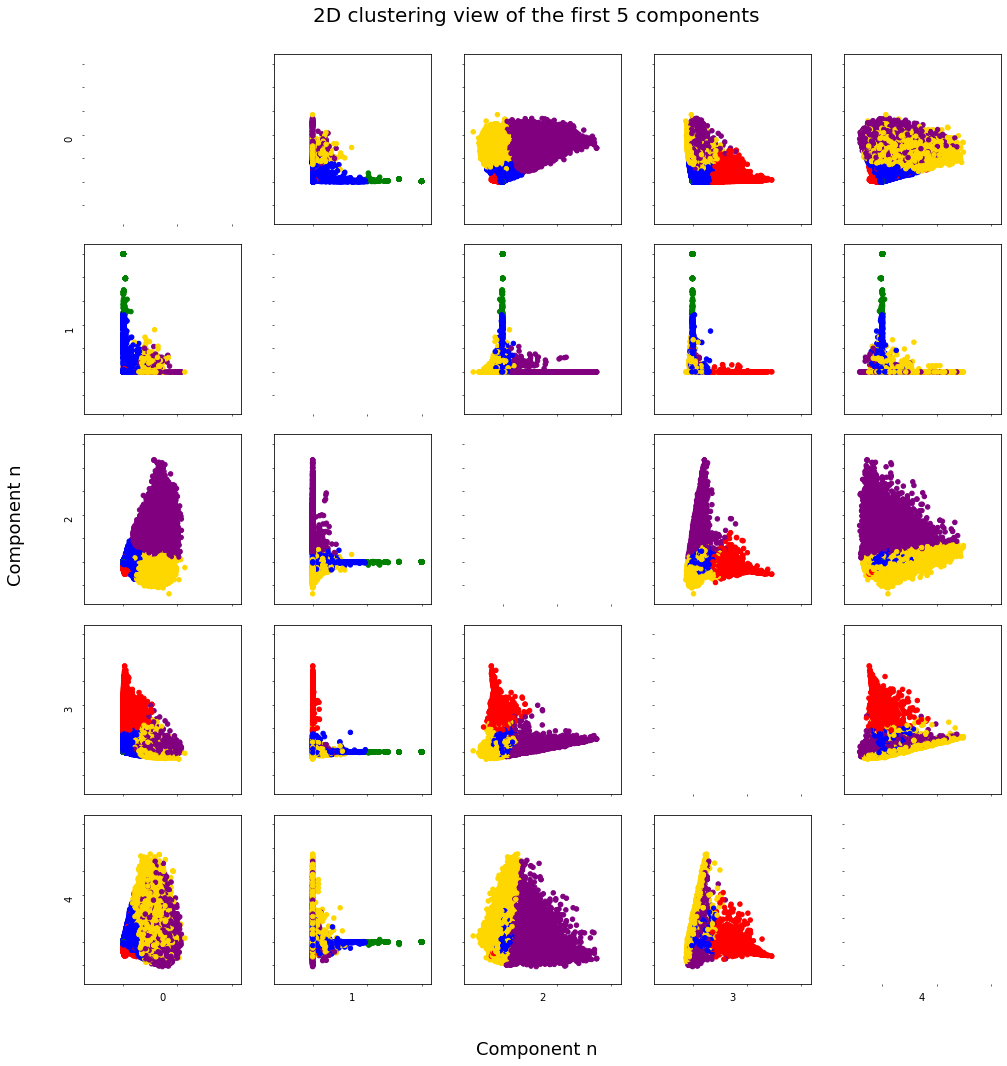

In [9]:
col = df_plot['Cluster'].map({0:'b', 1:'r', 2: 'g', 3:'purple', 4:'gold'})

# variable for first n dimensions we want to plot
n = 5

# visualize the clusters by first n dimensions (reduced)
fig, ax = plt.subplots(n, n, sharex=True, sharey=True, figsize=(15,15))
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# plot it
k = 0
for i in range(0,n):
    for j in range(0,n):
        if i != j:
            df_plot.plot(kind = 'scatter', x=j, y=i, c=col, ax = ax[i][j], fontsize = 18)
        else:
            ax[i][j].set_xlabel(i)
            ax[i][j].set_ylabel(j)
            ax[i][j].set_frame_on(False)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.suptitle('2D clustering view of the first {} components'.format(n), fontsize = 20)
fig.text(0.5, 0.01, 'Component n', ha='center', fontsize = 18)
fig.text(0.01, 0.5, 'Component n', va='center', rotation='vertical', fontsize = 18)

In [13]:
df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = df['lyrics']
    y = df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = 'english')
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


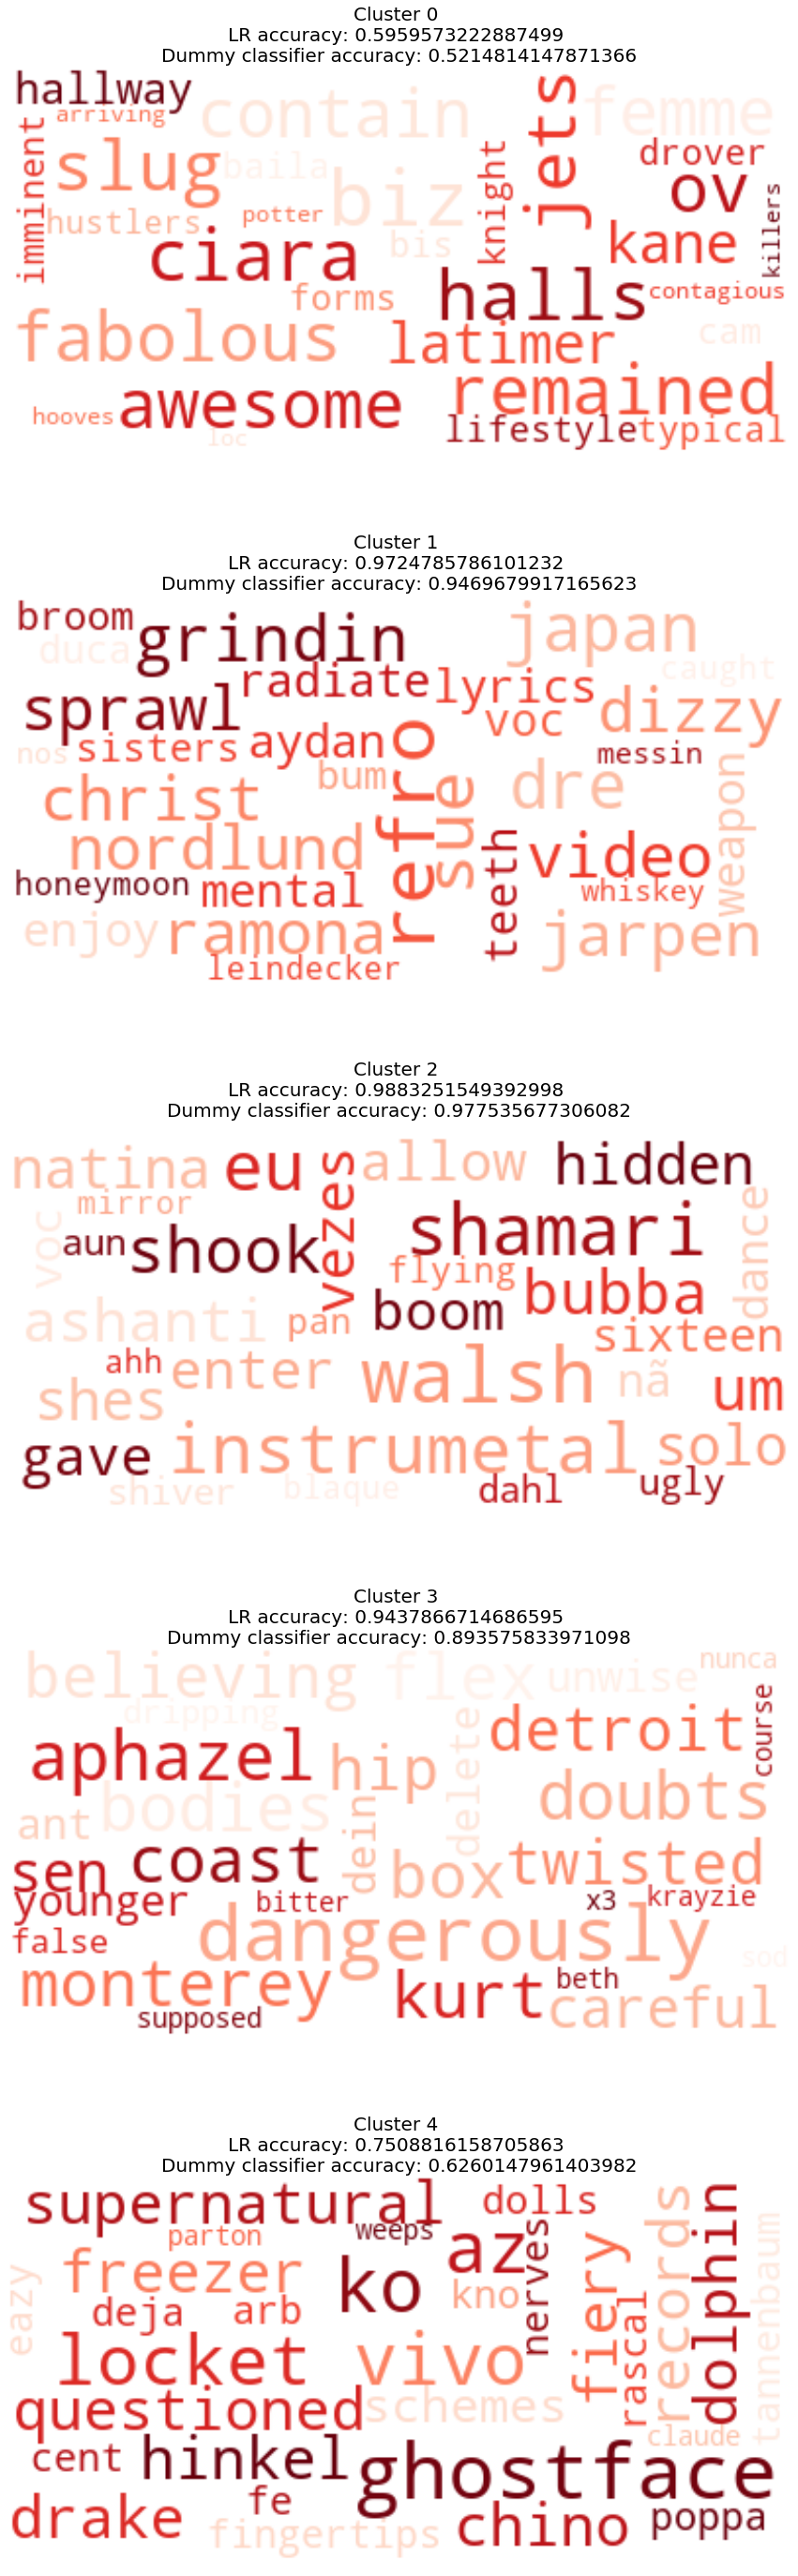

In [14]:
fig, ax = plt.subplots(n_clusters, sharex=True, figsize=(15,10*n_clusters))

for i in range(0, n_clusters):
    d, acc, acc_d = generate_text(i)
    wordcloud = WordCloud(max_font_size=40, collocations=False, colormap = 'Reds', background_color = 'white').fit_words(d)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title('Cluster {} \nLR accuracy: {} \nDummy classifier accuracy: {}'.format(i, acc, acc_d), fontsize = 20)
    ax[i].axis("off")

In [15]:
no_topics = 5

c = CountVectorizer(stop_words='english')
X_text_c = c.fit_transform(df['lyrics'])

lda = LatentDirichletAllocation(learning_method = 'online', n_components=no_topics, random_state=0).fit(X_text_c)
X_text_c_feature_names = c.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, X_text_c_feature_names, no_top_words)

Topic 0:
la que el en te tu es ich se mi
Topic 1:
like got shit ain man nigga ya fuck em money
Topic 2:
ll life time away ve love world heart eyes just
Topic 3:
don know love just oh got like want baby ll
Topic 4:
na da di mi che non ni la dem ba


### analyzing drug references in songs

In [16]:
df = df[df['word_count'] != 1]
df['word_count'].groupby(df['genre']).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,14323.0,186.913426,82.254845,3.0,129.0,171.0,231.0,1366.0
Electronic,7620.0,202.111680,135.602990,2.0,110.0,177.0,264.0,1920.0
Folk,2108.0,192.566888,115.198695,4.0,121.0,175.0,244.0,2393.0
Hip-Hop,24765.0,491.640299,237.307748,2.0,341.0,486.0,629.0,8195.0
Indie,3104.0,199.693621,106.541654,3.0,128.0,184.0,249.0,1262.0
Jazz,7825.0,175.237188,95.478588,2.0,110.0,153.0,216.0,1040.0
Metal,22995.0,174.652794,110.359008,2.0,105.0,155.0,220.0,2423.0
Not Available,23317.0,215.860831,131.510207,2.0,132.0,192.0,273.0,2570.0
Other,5183.0,224.267992,139.287456,3.0,128.0,193.0,286.0,1569.0


In [27]:
df100 = df.loc[df['word_count'] <= 100]
df100

,index,song,year,artist,genre,lyrics,word_count
43,43,diamonds,2007,beyonce-knowles,Pop,"Square-cut or pear shaped, These rocks don't l...",28.0
78,78,god-made-you-beautiful,2013,beyonce-knowles,Pop,When you were born The angels sighed in deligh...,85.0
83,83,i-m-glad-there-s-you,2010,beyonce-knowles,Pop,In this world Of ordinary people Exraordinary ...,92.0
85,85,freakdum-dresses,2010,beyonce-knowles,Pop,it's about getting our freakdum drsses on,7.0
89,89,helo,2012,beyonce-knowles,Pop,baby you know i love you baby you know i need ...,35.0
149,149,beyonce-interlude,2006,beyonce-knowles,Pop,I believe that harmonies are colors Every time...,36.0
160,160,forward,2016,beyonce-knowles,Pop,Forward Best foot first just in case When we m...,70.0
181,181,i-care-remix,2011,beyonce-knowles,Pop,Beyonce Ft. David Jassy - I Care (Remix) Beyon...,16.0
188,188,loving-a-woman,2011,beyonce-knowles,Pop,Beyonce Knowles ft. Mary J. Blige - Loving A W...,10.0
226,226,kim-em-out,2008,beyonce-knowles,Pop,I think that we should break up Theres no reas...,69.0


In [28]:
df1000 = df.loc[df['word_count'] >= 1000]
df1000

,index,song,year,artist,genre,lyrics,word_count
95,95,get-me-bodied,2006,beyonce-knowles,Pop,"Nine, four, eight, one B day Mission one: I'm-...",1122.0
113,113,get-me-bodied-extended-remix-bonus-track,2006,beyonce-knowles,Pop,"Nine, four, eight, one B'day Mission one, Ima ...",1014.0
1590,1590,tour-hip-hop-version,2006,capleton,Electronic,Yeah I say straighten yuh crooked ways Blessed...,1034.0
2339,2339,burnt,2007,del-the-funky-homosapien,Hip-Hop,"DEL: Mista, twista, get ya every single time w...",1068.0
7464,7464,stan,2006,dido,Pop,My tea's gone cold I'm wondering why I Got out...,1238.0
8855,8855,fuck-you,2006,50-cent,Hip-Hop,"Pain in da ass, fuck you Pain in da ass, fuck ...",1079.0
10318,10318,we-don-t-die-we-multiply-wddwm,2013,187-mobstaz,Not Available,-MIZTAH BE HERE COMES THE STORM RUSHIN'IN DONT...,2570.0
11208,11208,r-i-p,2006,dirty,Rock,(Spoken by the Gangsta) Hmmph! A dedication to...,1242.0
11217,11217,ride,2006,dirty,Rock,"Umm, yes, yes, yes, why'all Let's ride, let's ...",1140.0
11218,11218,the-pimp-da-gangsta,2006,dirty,Rock,It's the it's the eerrie pimp eerrie pimp eerr...,1274.0


In [29]:
del df100, df1000 
df_clean = df[df['word_count'] >= 100]
df_clean = df[df['word_count'] <= 1000]
df_clean['word_count'].groupby(df_clean['genre']).describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Country,14386.0,186.004379,82.416826,1.0,128.0,171.0,231.00,895.0
Electronic,7962.0,192.795152,136.173372,1.0,100.0,170.0,259.00,990.0
Folk,2241.0,179.562249,108.819267,1.0,111.0,168.0,238.00,998.0
Hip-Hop,24404.0,476.774176,209.424187,1.0,337.0,480.0,618.25,1000.0
Indie,3146.0,195.974889,104.568969,1.0,126.0,182.0,248.00,952.0
Jazz,7969.0,171.958339,96.949811,1.0,108.0,152.0,215.00,935.0
Metal,23746.0,168.427061,108.776466,1.0,100.0,152.0,217.00,999.0
Not Available,23917.0,209.216875,129.605487,1.0,126.0,189.0,269.00,994.0
Other,5186.0,223.320671,136.448083,1.0,127.0,193.0,285.00,986.0


In [22]:
genre = df.groupby(['genre'],as_index=False).count()
genre2 = genre[['genre','song']]
genre2

,genre,song
0,Country,14323
1,Electronic,7620
2,Folk,2108
3,Hip-Hop,24765
4,Indie,3104
5,Jazz,7825
6,Metal,22995
7,Not Available,23317
8,Other,5183
9,Pop,40263


In [23]:
liquor = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('liquor')].count()))
liquor.reset_index(inplace=True)
liquor.columns = ['genre', 'liquor_lyrics']
liquor


,genre,liquor_lyrics
0,Country,49
1,Electronic,12
2,Folk,8
3,Hip-Hop,853
4,Indie,4
5,Jazz,11
6,Metal,37
7,Not Available,58
8,Other,23
9,Pop,56


In [24]:
beer = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('beer')].count()))
beer.reset_index(inplace=True)
beer.columns = ['genre', 'beer_lyrics']
beer

,genre,beer_lyrics
0,Country,341
1,Electronic,26
2,Folk,34
3,Hip-Hop,389
4,Indie,22
5,Jazz,45
6,Metal,72
7,Not Available,190
8,Other,23
9,Pop,137


In [25]:
wine = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('wine')].count()))
wine.reset_index(inplace=True)
wine.columns = ['genre', 'wine_lyrics']
wine

,genre,wine_lyrics
0,Country,456
1,Electronic,90
2,Folk,57
3,Hip-Hop,759
4,Indie,55
5,Jazz,161
6,Metal,427
7,Not Available,364
8,Other,70
9,Pop,535


In [26]:
pills = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('pills')].count()))
pills.reset_index(inplace=True)
pills.columns = ['genre', 'pills_lyrics']
pills

,genre,pills_lyrics
0,Country,36
1,Electronic,31
2,Folk,8
3,Hip-Hop,463
4,Indie,22
5,Jazz,16
6,Metal,99
7,Not Available,81
8,Other,18
9,Pop,77


In [27]:
weed = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('weed')].count()))
weed.reset_index(inplace=True)
weed.columns = ['genre', 'weed_lyrics']
weed

,genre,weed_lyrics
0,Country,73
1,Electronic,45
2,Folk,17
3,Hip-Hop,2145
4,Indie,25
5,Jazz,26
6,Metal,102
7,Not Available,106
8,Other,29
9,Pop,116


In [32]:
molly = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('molly')].count()))
molly.reset_index(inplace=True)
molly.columns = ['genre', 'molly_lyrics']
molly

,genre,molly_lyrics
0,Country,0
1,Electronic,0
2,Folk,0
3,Hip-Hop,187
4,Indie,0
5,Jazz,0
6,Metal,1
7,Not Available,13
8,Other,9
9,Pop,7


In [33]:
percocet = pd.DataFrame(df.groupby(['genre'])['lyrics'].apply(lambda x: x[x.str.contains('percocet')].count()))
percocet.reset_index(inplace=True)
percocet.columns = ['genre', 'percocet_lyrics']
percocet

,genre,percocet_lyrics
0,Country,0
1,Electronic,0
2,Folk,0
3,Hip-Hop,16
4,Indie,1
5,Jazz,0
6,Metal,1
7,Not Available,0
8,Other,0
9,Pop,1


In [34]:
import functools
dfs = [genre2,beer,wine,liquor,pills,weed,molly,percocet]
genre3 = functools.reduce(lambda left,right: pd.merge(left,right,on='genre', how='outer'), dfs)
genre3

,genre,song,beer_lyrics,wine_lyrics,liquor_lyrics,pills_lyrics,index,weed_lyrics,molly_lyrics,percocet_lyrics
0,Country,14323,341,456,49,36,0,73,0,0
1,Electronic,7620,26,90,12,31,1,45,0,0
2,Folk,2108,34,57,8,8,2,17,0,0
3,Hip-Hop,24765,389,759,853,463,3,2145,187,16
4,Indie,3104,22,55,4,22,4,25,0,1
5,Jazz,7825,45,161,11,16,5,26,0,0
6,Metal,22995,72,427,37,99,6,102,1,1
7,Not Available,23317,190,364,58,81,7,106,13,0
8,Other,5183,23,70,23,18,8,29,9,0
9,Pop,40263,137,535,56,77,9,116,7,1


In [35]:
genre3['wine_ratio'] = genre3['wine_lyrics'] / genre3['song']
genre3['liquor_ratio'] = genre3['liquor_lyrics'] / genre3['song']
genre3['pills_ratio'] = genre3['pills_lyrics'] / genre3['song']
genre3['weed_ratio'] = genre3['weed_lyrics'] / genre3['song']
genre3['molly_ratio'] = genre3['molly_lyrics'] / genre3['song']
genre3['percocet_ratio'] = genre3['percocet_lyrics'] / genre3['song']

genre3

,genre,song,beer_lyrics,wine_lyrics,liquor_lyrics,pills_lyrics,index,weed_lyrics,molly_lyrics,percocet_lyrics,wine_ratio,liquor_ratio,pills_ratio,weed_ratio,molly_ratio,percocet_ratio
0,Country,14323,341,456,49,36,0,73,0,0,0.031837,0.003421,0.002513,0.005097,0.000000,0.000000
1,Electronic,7620,26,90,12,31,1,45,0,0,0.011811,0.001575,0.004068,0.005906,0.000000,0.000000
2,Folk,2108,34,57,8,8,2,17,0,0,0.027040,0.003795,0.003795,0.008065,0.000000,0.000000
3,Hip-Hop,24765,389,759,853,463,3,2145,187,16,0.030648,0.034444,0.018696,0.086614,0.007551,0.000646
4,Indie,3104,22,55,4,22,4,25,0,1,0.017719,0.001289,0.007088,0.008054,0.000000,0.000322
5,Jazz,7825,45,161,11,16,5,26,0,0,0.020575,0.001406,0.002045,0.003323,0.000000,0.000000
6,Metal,22995,72,427,37,99,6,102,1,1,0.018569,0.001609,0.004305,0.004436,0.000043,0.000043
7,Not Available,23317,190,364,58,81,7,106,13,0,0.015611,0.002487,0.003474,0.004546,0.000558,0.000000
8,Other,5183,23,70,23,18,8,29,9,0,0.013506,0.004438,0.003473,0.005595,0.001736,0.000000
9,Pop,40263,137,535,56,77,9,116,7,1,0.013288,0.001391,0.001912,0.002881,0.000174,0.000025


In [ ]:
## most common words

In [30]:
cb = df_clean[(df_clean['artist'] == 'chris-brown')]
cb.head(3)

rap = list(cb['lyrics'])
word=[]
for i in range(0,len(rap)):
    kk = rap[i].replace("\n"," ")
    kk = rap[i].replace("/"," ")
    kk = rap[i].replace(","," ")
    s=kk.split(' ')
    o = [x for x in s if x]
    word.append(o)
    
word = [j for i in word for j in i]
word[:20]

['We',
 'can',
 'jet',
 'believe',
 'it',
 'I',
 'know',
 'that',
 'you',
 "won't",
 'And',
 'yes',
 "there's",
 'a',
 "feelin'",
 'We',
 'both',
 'need',
 'to',
 'know']

In [32]:
import nltk
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
el = ["i'm","get","got","like","oh","ooh","see","say","one","aint","yeah","ya","way"] #give more stop words
stop = set(stopwords.words('english'))
word = [word.lower() for word in word]
words = [i for i in word if i not in stop]
words = [i for i in words if i not in el]

In [34]:
import re
for i in range(0,len(words)):
    words[i] = re.sub(r'[^\w\s]','',words[i])
    
words = [x for x in words if x]

In [35]:
from collections import Counter
labels, values = zip(*Counter(words).items())

In [36]:
w = Counter(words)
s = w.most_common(20)
x , y = zip(*(s))

In [37]:
w

Counter({'jet': 21,
         'believe': 107,
         'know': 2379,
         'yes': 110,
         'theres': 149,
         'feelin': 50,
         'need': 801,
         'let': 1007,
         'us': 274,
         'start': 87,
         'time': 646,
         'lets': 340,
         'travel': 15,
         'light': 108,
         'and': 35,
         'im': 388,
         'gonna': 352,
         'take': 835,
         'anywhere': 31,
         'wanna': 1378,
         'go': 1064,
         'if': 11,
         'ride': 119,
         'town': 33,
         'party': 186,
         'drink': 120,
         'london': 9,
         'dance': 169,
         'paris': 8,
         'chase': 28,
         'love': 2019,
         'shout': 7,
         'real': 231,
         'loud': 85,
         'hear': 205,
         'tonight': 329,
         'night': 499,
         'evening': 4,
         'well': 170,
         'til': 104,
         'morning': 73,
         'ill': 523,
         'watch': 90,
         'shine': 38,
         'instrumental': 

In [38]:
s

[('girl', 2916),
 ('know', 2379),
 ('love', 2019),
 ('baby', 1745),
 ('wanna', 1378),
 ('aint', 1229),
 ('cause', 1147),
 ('go', 1064),
 ('want', 1064),
 ('let', 1007),
 ('right', 858),
 ('make', 844),
 ('take', 835),
 ('need', 801),
 ('back', 754),
 ('nigga', 750),
 ('cant', 724),
 ('tell', 658),
 ('time', 646),
 ('gotta', 619)]

In [61]:
 pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install chart-studio

Note: you may need to restart the kernel to use updated packages.


In [39]:
import plotly.graph_objs as go
#from plotly.plotly import iplot
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
#from chart_studio.plotly import iplot

df = [go.Bar(x=x,y=y)]
layout = go.Layout(
    title='Words in Chris Brown Lyrics ',
    xaxis=dict(
        title='Words Used',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Number of times it was used',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
iplot(go.Figure(data= df, layout = layout))

In [43]:
unique_words = sorted(set(words))
len(unique_words)

8178

8178 unique words used by Chris Brown

In [ ]:
### generating lyrics

In [67]:
import sys
sys.executable

'C:\\Users\\user\\Anaconda3\\python.exe'

In [72]:
pip install dask==0.15.0

  Found existing installation: dask 2.1.0
    Uninstalling dask-2.1.0:
      Successfully uninstalled dask-2.1.0
Note: you may need to restart the kernel to use updated packages.


ERROR: distributed 2.1.0 has requirement dask>=2, but you'll have dask 0.15.0 which is incompatible.


In [71]:
pip install tensorflow==1.2

Note: you may need to restart the kernel to use updated packages.


  ERROR: Could not find a version that satisfies the requirement tensorflow==1.1 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.1.0rc0)
ERROR: No matching distribution found for tensorflow==1.1


In [ ]:
ctc = tf.nn

In [7]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install tensorflow --user

  Stored in directory: C:\Users\lenovo\AppData\Local\pip\Cache\wheels\2c\b1\94\43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Stored in directory: C:\Users\lenovo\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\lenovo\AppData\Local\pip\Cache\wheels\a7\15\a0\0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
  Stored in directory: C:\Users\lenovo\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Successfully built opt-einsum gast absl-py termcolor
Note: you may need to restart the kernel to use updated packages.


tensorboard 2.0.2 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
  The script markdown_py.exe is installed in 'C:\Users\lenovo\AppData\Roaming\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  The scripts pyrsa-decrypt.exe, pyrsa-encrypt.exe, pyrsa-keygen.exe, pyrsa-priv2pub.exe, pyrsa-sign.exe and pyrsa-verify.exe are installed in 'C:\Users\lenovo\AppData\Roaming\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  The script google-oauthlib-tool.exe is installed in 'C:\Users\lenovo\AppData\Roaming\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  The script tensorboard.exe is installed in 'C:\Users\leno

In [17]:
pip install tensorflow --ignore-installed

  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
Note: you may need to restart the kernel to use updated packages.


In [21]:
import sys
sys.executable
sys.path.append('c:/users/lenovo/appdata/roaming/python/python37/site-packages')

In [22]:
import keras

Using TensorFlow backend.


In [25]:
import numpy as np

In [23]:
from keras.models import Sequential
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

mapping these 8000+ words 

In [99]:
rap = np.array(rap)
lyric = (''.join(rap))
l = set(lyric)
len(l)

101

In [100]:
vocab= [k for k in l] 
char_ix={c:i for i,c in enumerate(vocab)}
ix_char={i:c for i,c in enumerate(vocab)}

maxlen=1
vocab_size=len(vocab)

In [95]:
l.remove(' ') 
l.remove('!') 
l.remove('i') 
l.remove('/xad') 
l.remove('/x80') 


KeyError: ' '

In [86]:
  #,' ',"'", '0', '1', '2', '3', '4', '5','6','7','8','9')
l.remove('\x97') 
l.remove('\x99') 


In [88]:
l.remove('\xad')

In [96]:
l

{'"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '=',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '[',
 ']',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '{',
 '}',
 '¡',
 '¢',
 '¦',
 '©',
 '±',
 '¹',
 'Â',
 'Ã',
 'á',
 '∧'}

In [101]:
sentences=[]
next_char=[]
for i in range(len(lyric)-maxlen-1):
    sentences.append(lyric[i:i+maxlen])
    next_char.append(lyric[i+maxlen])
sentences

['W',
 'e',
 ' ',
 'c',
 'a',
 'n',
 ' ',
 'j',
 'e',
 't',
 ',',
 ' ',
 'b',
 'e',
 'l',
 'i',
 'e',
 'v',
 'e',
 ' ',
 'i',
 't',
 ' ',
 'I',
 ' ',
 'k',
 'n',
 'o',
 'w',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 'y',
 'o',
 'u',
 ' ',
 'w',
 'o',
 'n',
 "'",
 't',
 ' ',
 'A',
 'n',
 'd',
 ' ',
 'y',
 'e',
 's',
 ',',
 ' ',
 't',
 'h',
 'e',
 'r',
 'e',
 "'",
 's',
 ' ',
 'a',
 ' ',
 'f',
 'e',
 'e',
 'l',
 'i',
 'n',
 "'",
 ' ',
 'W',
 'e',
 ' ',
 'b',
 'o',
 't',
 'h',
 ' ',
 'n',
 'e',
 'e',
 'd',
 ' ',
 't',
 'o',
 ' ',
 'k',
 'n',
 'o',
 'w',
 ' ',
 'L',
 'e',
 't',
 ' ',
 'u',
 's',
 ' ',
 's',
 't',
 'a',
 'r',
 't',
 ' ',
 'n',
 'o',
 'w',
 ' ',
 'I',
 't',
 "'",
 's',
 ' ',
 't',
 'h',
 'a',
 't',
 ' ',
 't',
 'i',
 'm',
 'e',
 ' ',
 'S',
 'o',
 ' ',
 'l',
 'e',
 't',
 "'",
 's',
 ' ',
 't',
 'r',
 'a',
 'v',
 'e',
 'l',
 ' ',
 'A',
 'n',
 'd',
 ' ',
 's',
 'e',
 'e',
 ' ',
 't',
 'h',
 'e',
 ' ',
 'l',
 'i',
 'g',
 'h',
 't',
 ' ',
 '(',
 'A',
 'n',
 'd',
 ' ',
 'I',
 "'",
 'm'

In [102]:
X=np.zeros((len(sentences),maxlen,vocab_size))
y=np.zeros((len(sentences),vocab_size))
for ix in range(len(sentences)):
    y[ix,char_ix[next_char[ix]]]=1
    for iy in range(maxlen):
        X[ix,iy,char_ix[sentences[ix][iy]]]=1

In [103]:
from keras.layers import Activation,LSTM,Dense
from keras.optimizers import Adam

In [104]:
model=Sequential()
model.add(LSTM(128,input_shape=(maxlen,vocab_size)))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
model.summary()
model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               117760    
_________________________________________________________________
dense_1 (Dense)              (None, 101)               13029     
_________________________________________________________________
activation_1 (Activation)    (None, 101)               0         
Total params: 130,789
Trainable params: 130,789
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.fit(X,y,epochs=20,batch_size=128)
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("model.h5")
#print("Saved model to disk")

Epoch 1/20
1275342/1275342 [==============================] - 105s 82us/step - loss: 2.4397
Epoch 2/20
1275342/1275342 [==============================] - 88s 69us/step - loss: 2.4207
Epoch 3/20
1275342/1275342 [==============================] - 88s 69us/step - loss: 2.4180
Epoch 4/20
1275342/1275342 [==============================] - 88s 69us/step - loss: 2.4165
Epoch 5/20
1275342/1275342 [==============================] - 89s 70us/step - loss: 2.4155
Epoch 6/20
1275342/1275342 [==============================] - 90s 71us/step - loss: 2.4149
Epoch 7/20
1275342/1275342 [==============================] - 92s 72us/step - loss: 2.4142
Epoch 8/20
1275342/1275342 [==============================] - 91s 72us/step - loss: 2.4138
Epoch 9/20
1275342/1275342 [==============================] - 93s 73us/step - loss: 2.4136
Epoch 10/20
1275342/1275342 [==============================] - 94s 74us/step - loss: 2.4133
Epoch 11/20
1275342/1275342 [==============================] - 94s 74us/step - loss: 2.4

In [108]:
maxlen = 1
import random
generated=''
start_index=random.randint(0,len(lyric)-maxlen-1)
sent=lyric[start_index:start_index+maxlen]
generated+=sent
for i in range(1900):
    x_sample=generated[i:i+maxlen]
    x=np.zeros((1,maxlen,vocab_size))
    for j in range(maxlen):
        x[0,j,char_ix[x_sample[j]]]=1
    probs=model.predict(x)
    probs=np.reshape(probs,probs.shape[1])
    ix=np.random.choice(range(vocab_size),p=probs.ravel())
    generated+=ix_char[ix]

In [110]:
generated.split(" ")

['e',
 'at',
 'ary',
 "I'tho",
 't',
 'yit',
 'I',
 'If*ghit',
 'ucal',
 'tcaikitilout',
 'I',
 'tr',
 "Dolout'my,",
 't',
 'wa',
 't',
 'aneretre',
 'heve',
 'toran',
 'I',
 "Wan'ry",
 'syomeditouto',
 "lin'tole",
 'w',
 'It',
 'Hodonnnginyonealigo',
 'wipust',
 'wino',
 'w',
 'Ovemaris',
 "difondownstwetrun'm",
 's',
 'Dsland',
 '[REverndet',
 "I't",
 '(cklofeet',
 'bann',
 'jug',
 'g',
 'itwa',
 'it',
 'bor',
 'vedig',
 'jur',
 'by',
 'le,',
 'wag,',
 'nyoup',
 'ir',
 'h',
 'yen',
 'ched',
 'Ming',
 "I'take",
 'a',
 'dall',
 'Yomy',
 'our',
 'd',
 'lke',
 'h',
 'Poban',
 'cupepou',
 'thar',
 't',
 'to',
 'p',
 "I'vealoown",
 't',
 'yo',
 'oavea',
 'shr',
 'Dalyay,',
 'abes',
 'lyble,',
 'rerevecicerane',
 'Wh',
 'ckn',
 't,',
 'I',
 'sove',
 'pp',
 'Itifre',
 'nathe',
 'itt',
 't',
 'haik',
 'me,',
 'Wondow',
 'r',
 'me',
 'con,',
 'm',
 'yome',
 'e',
 'Anod',
 'cup',
 'ep',
 'myebyoourf',
 'whe',
 'Sanapp',
 'y,',
 'ane,',
 'enet',
 'h',
 'y',
 'merk,',
 'Itands',
 'waknthat',
 'Ve

In [117]:
rap = np.array(rap)
lyric1 = (''.join(rap))
l1 = set(lyric)
len(l1)

vocab1= [k for k in l1] 
char_ix1={c:i for i,c in enumerate(vocab1)}
ix_char1={i:c for i,c in enumerate(vocab1)}

maxlen1= 5
vocab_size=len(vocab)

In [118]:

#l1.remove(' ') 
#l1.remove('!') 
#l1.remove('i') 
#l1.remove('/xad') 
#l1.remove('/x80') 
  #,' ',"'", '0', '1', '2', '3', '4', '5','6','7','8','9')
#l1.remove('\x97') 
#l1.remove('\x99') 


sentences1=[]
next_char1=[]
for i in range(len(lyric1)-maxlen1-1):
    sentences1.append(lyric1[i:i+maxlen1])
    next_char1.append(lyric1[i+maxlen1])
sentences1

['We ca',
 'e can',
 ' can ',
 'can j',
 'an je',
 'n jet',
 ' jet,',
 'jet, ',
 'et, b',
 't, be',
 ', bel',
 ' beli',
 'belie',
 'eliev',
 'lieve',
 'ieve ',
 'eve i',
 've it',
 'e it ',
 ' it I',
 'it I ',
 't I k',
 ' I kn',
 'I kno',
 ' know',
 'know ',
 'now t',
 'ow th',
 'w tha',
 ' that',
 'that ',
 'hat y',
 'at yo',
 't you',
 ' you ',
 'you w',
 'ou wo',
 'u won',
 " won'",
 "won't",
 "on't ",
 "n't A",
 "'t An",
 't And',
 ' And ',
 'And y',
 'nd ye',
 'd yes',
 ' yes,',
 'yes, ',
 'es, t',
 's, th',
 ', the',
 ' ther',
 'there',
 "here'",
 "ere's",
 "re's ",
 "e's a",
 "'s a ",
 's a f',
 ' a fe',
 'a fee',
 ' feel',
 'feeli',
 'eelin',
 "elin'",
 "lin' ",
 "in' W",
 "n' We",
 "' We ",
 ' We b',
 'We bo',
 'e bot',
 ' both',
 'both ',
 'oth n',
 'th ne',
 'h nee',
 ' need',
 'need ',
 'eed t',
 'ed to',
 'd to ',
 ' to k',
 'to kn',
 'o kno',
 ' know',
 'know ',
 'now L',
 'ow Le',
 'w Let',
 ' Let ',
 'Let u',
 'et us',
 't us ',
 ' us s',
 'us st',
 's sta',
 ' star',


In [ ]:
X1=np.zeros((len(sentences1),maxlen1,vocab_size))
y1=np.zeros((len(sentences1),vocab_size))
for ix in range(len(sentences1)):
    y1[ix,char_ix1[next_char1[ix]]]=1
    for iy in range(maxlen1):
        X1[ix,iy,char_ix[sentences1[ix][iy]]]=1

word based

In [ ]:
from unidecode import unidecode
def get_tokenized_lines(df):
    words = []
    
    for index, row in df['lyrics'].iteritems():
        row = str(row).lower()
        for line in row.split('\n'):
            new_words = re.findall(r"\b[a-z']+\b", unidecode(line))
            words = words + new_words
        
    return words

In [ ]:
all_lyric_lines = get_tokenized_lines(eminem)


In [ ]:
SEQ_LENGTH = 50 + 1
sequences = list()

for i in range(SEQ_LENGTH, len(all_lyric_lines)):
    seq = all_lyric_lines[i - SEQ_LENGTH: i]
    sequences.append(seq)

print('Total Sequences: %d' % len(sequences))

In [ ]:
vocab = set(all_lyric_lines)

word_to_index = {w: i for i, w in enumerate(vocab)}
index_to_word = {i: w for w, i in word_to_index.items()}
word_indices = [word_to_index[word] for word in vocab]
vocab_size = len(vocab)

print('vocabulary size: {}'.format(vocab_size))

In [ ]:
def get_tokenized_lines(lines, seq_len):
    tokenized = np.zeros((len(lines), seq_len))
    
    for r, line in enumerate(lines):
        for c, word in enumerate(line):
            tokenized[r, c] = word_to_index[word]

    return tokenized


In [ ]:
tokenized_seq = get_tokenized_lines(sequences, SEQ_LENGTH)


In [ ]:
X, y = tokenized_seq[:, :-1], tokenized_seq[:, -1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = len(X[0])

print("X_shape", X.shape)
print("y_shape", y.shape)

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=seq_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, batch_size=128, epochs=20)

In [ ]:
seed_text = "Hailie i know you miss your mom and i know you miss your dad well i'm gone but i'm trying to give you the life that i never had i can see you're sad even when you smile even when you laugh i can see it in your eyes deep inside"

In [ ]:
def texts_to_sequences(texts, word_to_index):
    indices = np.zeros((1, len(texts)), dtype=int)
    
    for i, text in enumerate(texts):
        indices[:, i] = word_to_index[text]
        
    return indices

In [ ]:
def my_pad_sequences(seq, maxlen):
    start = seq.shape[1] - maxlen
    
    return seq[:, start: start + maxlen]

In [ ]:
def generate_seq(model, word_to_index, seq_length, seed_text, n_words):
    result = list()
    in_text = seed_text

    for _ in range(n_words):
        encoded = texts_to_sequences(in_text.split()[1:], word_to_index)
        encoded = my_pad_sequences(encoded, maxlen=seq_length)
        
        yhat = model.predict_classes(encoded, verbose=0)
        out_word = ''
    
        for word, index in word_to_index.items():
            if index == yhat:
                out_word = word
                break
        
        in_text += ' ' + out_word
        result.append(out_word)
        
    return ' '.join(result)

In [ ]:
generated = generate_seq(model, word_to_index, seq_length, seed_text, 50)
print(generated)

In [ ]:
import numpy as np
import pandas as pd
import random
import sys
import os

lyric = df[df['artist']=='chris-brown']
DP_text = lyric['lyrics'].str.cat(sep='\n').lower()

print(DP_text[:100])
print('corpus length:', len(DP_text))

In [ ]:
chars = sorted(list(set(DP_text)))
print(chars)
print('total chars:', len(chars))

In [ ]:
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

print(char_to_int)

### create sentences

In [ ]:
seq_length = 50 # The sentence window size
step = 1 # The steps between the windows
sentences = []
next_chars = []

# Create Target and sentences window
for i in range(0, len(DP_text) - seq_length, step):
    sentences.append(DP_text[i: i + seq_length]) # range from current index to sequence length charaters 
    next_chars.append(DP_text[i + seq_length]) # the next character
    
sentences = np.array(sentences)
next_chars = np.array(next_chars)

#Print Sentence Window and next charaters
print('Sentence Window')
print (sentences[:5])
print('Target charaters')
print (next_chars[:5])
print('Number of sequences:', len(sentences))

pytorch

In [ ]:
def getdata(sentences, next_chars, batch_size):
    X = np.zeros((batch_size, maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((batch_size, len(chars)), dtype=np.bool)
    length = len(sentences)
    index = 0
    while True:
        if index + batch_size >= length:
            index = 0
        X.fill(0)
        y.fill(0)
        for i in range(batch_size):
            sentence = sentences[index]
            for t, char in enumerate(sentence):
                X[i, t, char_indices[char]] = 1
            y[i, char_indices[next_chars[i]]] = 1
            index = index + 1
        yield X, y

In [ ]:
train_x,train_y = getdata(sentences, next_chars)
print('Shape of training_x:', train_x.shape)
print('Shape of training_y:', train_y.shape)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

class Simple_LSTM(nn.Module):
    def __init__(self,n_vocab,hidden_dim, embedding_dim,dropout = 0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,dropout = dropout,num_layers = 2)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # for LSTM, input should be (Sequnce_length,batchsize,hidden_layer), so we need to transpose the input
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Only need to keep the last character 
        ht=lstm_out[-1] 
        out = self.fc(ht)
        return out

In [ ]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long).cuda()
Y_train_tensor = torch.tensor(train_y, dtype=torch.long).cuda()

In [ ]:
X_train_tensor = torch.tensor(train_x, dtype=torch.long).cuda()
Y_train_tensor = torch.tensor(train_y, dtype=torch.long).cuda()